# Analyze the target prob-weighted beta value matrix

## Package importing

In [133]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import os
import re

# Create PCA plots
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns

# Filter features
from scipy.stats import mannwhitneyu
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegressionCV

# Heatmap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

import colorsys
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay

## Data loading

In [134]:
# Create nested dictionary structure for easier access
feature_type = 'dmrs'
# feature_type = 'cpgs'

dfs = {
    'Train': pd.read_csv(f'../results/20250318_train/generate/prob_weighted_{feature_type}.tsv', sep='\t').dropna(axis=1).drop(columns=['label']),
    'Validation': pd.read_csv(f'../results/20250318_val/generate/prob_weighted_{feature_type}.tsv', sep='\t').dropna(axis=1).drop(columns=['label'])
}

# Filter for common columns between train and val for each assembly type
common_cols = set(dfs['Train'].columns) & set(dfs['Validation'].columns)
dfs['Train'] = dfs['Train'][list(common_cols)]
dfs['Validation'] = dfs['Validation'][list(common_cols)]

# Load and combine metadata
train_metadata = pd.read_csv(f'../results/summary/train_meta.csv')
val_metadata = pd.read_csv(f'../results/summary/val_meta.csv')
train_metadata['state'] = 'Arrest'
meta = pd.concat([train_metadata, val_metadata], axis=0)
meta['sample'] = meta['sample'].apply(lambda x: x.replace('H1', ''))
meta['label'] = meta['label'].apply(lambda x: x.replace('T21+Indel_21', 'T21'))
meta['label'] = meta['label'].apply(lambda x: x.replace('T18[50%]', 'T18'))

# Merge metadata with each dataset
for split in list(dfs.keys()):
    df = dfs[split].copy()
    df['sample'] = df['sample'].apply(lambda x: x.replace('H1', ''))
    df = pd.merge(df, meta.drop_duplicates(), on='sample', how='inner')
    dfs[split] = df


In [135]:
# Convert beta to M function
def convert_beta_to_M(df):
    def beta_to_M(beta):
        try:
            # Convert beta to float if necessary.
            b = float(beta)/100
        except (ValueError, TypeError):
            return np.nan
        # Clip beta to avoid division by zero or log of zero.
        b = min(max(b, 1e-5), 1 - 1e-5)
        return np.log2(b / (1 - b))
    
    new_df = df.copy()
    for col in new_df.columns:
        if ":" in col:
            # Apply conversion elementwise
            new_df[col] = new_df[col].apply(beta_to_M)
    return new_df

In [136]:
# PCA plot

def pca_feature_selection(df, labels_to_keep = ['T16', 'Normal']):
    # -----------------------------
    # Data Loading and Pre-Filtering
    # -----------------------------
    
    # Extract features and labels
    labels = df['label']
    feature_cols = [col for col in df.columns if ':' in col]  # Select CpG site columns
    X = df[feature_cols]
    X = X.dropna(axis=1)  # Remove features with missing values
    
    features = []

    X_final = X
    
    # # **1. Remove low-variance features**
    # var_thresh = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed
    # X_filtered = pd.DataFrame(
    #     var_thresh.fit_transform(X),
    #     columns=X.columns[var_thresh.get_support()],
    #     index=X.index
    # )
    # print(f"Step 1: Low-variance filtering: {X.shape[1]} to {X_filtered.shape[1]} features retained.")
    
    # # **2. Remove highly correlated features (unsupervised)**
    # corr_matrix = X_filtered.corr().abs()
    # upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
    # X_final = X_filtered.drop(columns=to_drop)
    # print(f"Step 2: Remove highly correlated features: {X_filtered.shape[1]} to {X_final.shape[1]} features retained.")
    
    # -----------------------------
    # 3. PCA-based Feature Selection
    # -----------------------------
    # Perform PCA and keep only the first two principal components
    pca = PCA(n_components=2, random_state=42)
    pca.fit(X_final)
    
    # PCA components (loadings): shape (2, n_features)
    # We take the absolute values of the loadings since the sign is arbitrary.
    loadings = np.abs(pca.components_)
    
    # Compute a combined score for each feature using the Euclidean norm of its loadings on PC1 and PC2.
    combined_scores = np.sqrt(loadings[0]**2 + loadings[1]**2)
    
    # Create a Series with feature names and their combined score.
    score_series = pd.Series(combined_scores, index=X_final.columns)
    score_series_sorted = score_series.sort_values(ascending=False)

    feature_sorted = score_series_sorted.index

    return feature_sorted

def lasso_feature_selection(df, labels_to_keep = ['T16', 'Normal']):
    # -----------------------------
    # Data Loading and Pre-Filtering
    # -----------------------------
    
    # Extract features and labels
    labels = df['label']
    feature_cols = [col for col in df.columns if ':' in col]  # Select CpG site columns
    X = df[feature_cols]
    X = X.dropna(axis=1)  # Remove features with missing values
    
    # Filter for specified labels
    mask = labels.isin(labels_to_keep)
    X = X[mask]
    y = labels[mask]

    y = y.map({labels_to_keep[0]: 1, labels_to_keep[1]: 0})
    X_final = X
    
    # # **1. Remove low-variance features**
    # var_thresh = VarianceThreshold(threshold=0.01)
    # X_filtered = pd.DataFrame(
    #     var_thresh.fit_transform(X),
    #     columns=X.columns[var_thresh.get_support()],
    #     index=X.index
    # )
    # print(f"Step 1: Low-variance filtering: {X.shape[1]} to {X_filtered.shape[1]} features retained.")
    
    # # **2. Remove highly correlated features**
    # corr_matrix = X_filtered.corr().abs()
    # upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
    # X_final = X_filtered.drop(columns=to_drop)
    # print(f"Step 2: Remove highly correlated features: {X_filtered.shape[1]} to {X_final.shape[1]} features retained.")
    
    # -----------------------------
    # 3. Lasso-based Feature Selection
    # -----------------------------
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_final)
    
    # Fit Lasso with cross-validation to find optimal alpha
    lasso_cv = LassoCV(cv=5, random_state=42)
    lasso_cv.fit(X_scaled, y)
    
    # Get feature importance scores
    feature_importance = np.abs(lasso_cv.coef_)
    
    # Create a Series with feature names and their importance scores
    score_series = pd.Series(feature_importance, index=X_final.columns)
    score_series_sorted = score_series.sort_values(ascending=False)
    
    print(f"Step 3: Lasso selected {(feature_importance != 0).sum()} non-zero features")
    
    feature_sorted = score_series_sorted.index
    
    return feature_sorted

def single_pca_plot(df, feature_cols, labels_to_keep, title, new_df=None, plot_decision_boundary=True):
    # Helper function: Adjust base color using a gradient based on week.
    def get_gradient_color(base_color, week, min_week, max_week):
        norm = (week - min_week) / (max_week - min_week) if max_week != min_week else 0.5
        h, s, v = colorsys.rgb_to_hsv(*base_color)
        new_s = 0.1 + 0.9 * norm
        new_color = colorsys.hsv_to_rgb(h, new_s, v)
        return new_color

    # Compute global week range.
    if new_df is not None:
        combined_week = pd.concat([df['week'], new_df['week']])
        min_week, max_week = combined_week.min(), combined_week.max()
    else:
        min_week, max_week = df['week'].min(), df['week'].max()

    # Extract and standardize features.
    X = df[feature_cols]
    X_final = X.dropna(axis=1)
    kept_cols = X_final.columns
    title = f'{title} (n={X_final.shape[1]})'
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_final)
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # Get original labels, samples, weeks.
    labels = df['label']
    samples = df['sample']
    weeks = df['week']

    # Create a color mapping.
    palette = sns.color_palette("Set1", n_colors=len(labels_to_keep))
    label_colors = dict(zip(labels_to_keep, palette))
    sil_score = silhouette_score(X_pca, labels)
    orig_colors = [get_gradient_color(label_colors[label], week, min_week, max_week)
                   for label, week in zip(labels, weeks)]
    
    # Fit logistic regression on PCA data.
    clf = LogisticRegression(random_state=42)
    clf.fit(X_pca, labels)
    
    # Process new data if available.
    if new_df is not None:
        new_X = new_df[feature_cols][kept_cols]
        new_X_scaled = scaler.transform(new_X)
        new_X_pca = pca.transform(new_X_scaled)
        new_labels = new_df['label']
        new_samples = new_df['sample']
        new_weeks = new_df['week']
        new_colors = [get_gradient_color(label_colors[label], week, min_week, max_week)
                      for label, week in zip(new_labels, new_weeks)]
        
        # Compute confusion matrix for new data with proper label ordering.
        new_preds = clf.predict(new_X_pca)
        cm_new = confusion_matrix(new_labels, new_preds, labels=labels_to_keep)
    else:
        new_X_pca = None

    # Create one figure with two subplots.
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    ax = axes[0]
    
    # Plot PCA scatter (original data).
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=orig_colors, label='Original Data')
    
    # Plot the linear decision boundary if requested
    if plot_decision_boundary:
        x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
        x_vals = np.linspace(x_min, x_max, 100)
        if clf.coef_[0][1] != 0:
            y_vals = -(clf.coef_[0][0] * x_vals + clf.intercept_[0]) / clf.coef_[0][1]
            ax.plot(x_vals, y_vals, 'k--', label='Decision Boundary')
        else:
            x_line = -clf.intercept_[0] / clf.coef_[0][0]
            ax.axvline(x=x_line, color='k', linestyle='--', label='Decision Boundary')
    
    # Overlay new data if provided.
    if new_df is not None:
        ax.scatter(new_X_pca[:, 0], new_X_pca[:, 1], marker='x', c=new_colors, s=100, label='New Data')
        for i, sample in enumerate(new_samples):
            ax.annotate(sample, (new_X_pca[i, 0], new_X_pca[i, 1]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.7)
    
    # Annotate original data points.
    for i, sample in enumerate(samples):
        ax.annotate(sample, (X_pca[i, 0], X_pca[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)
    
    ax.set_title(f'{title}\nSilhouette Score: {sil_score:.3f}')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
    
    # Build legend.
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label, markersize=10)
                       for label, color in label_colors.items()]
    if plot_decision_boundary:
        legend_elements.append(plt.Line2D([0], [0], linestyle='--', color='k', label='Decision Boundary'))
    if new_df is not None:
        legend_elements.append(plt.Line2D([0], [0], marker='x', color='black', markerfacecolor='black', label='New Data', markersize=10))
    ax.legend(handles=legend_elements, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Right subplot: plot confusion matrix for new data.
    ax2 = axes[1]
    if new_df is not None:
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=labels_to_keep)
        cm_disp.plot(ax=ax2, cmap='Blues', values_format='d')
        ax2.set_title('Confusion Matrix (New Data)')
    else:
        ax2.text(0.5, 0.5, "No new data provided for confusion matrix", ha="center", va="center")
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

def single_pca_svm_plot(df, feature_cols, labels_to_keep, title, new_df=None, plot_decision_boundary=True):
    """
    This version uses an SVM with an RBF kernel for non-linear classification.
    It computes a non-linear (curving) decision boundary via a meshgrid and plots
    it along with the PCA scatter and new data confusion matrix.
    """
    def get_gradient_color(base_color, week, min_week, max_week):
        norm = (week - min_week) / (max_week - min_week) if max_week != min_week else 0.5
        h, s, v = colorsys.rgb_to_hsv(*base_color)
        new_s = 0.1 + 0.9 * norm
        new_color = colorsys.hsv_to_rgb(h, new_s, v)
        return new_color

    if new_df is not None:
        combined_week = pd.concat([df['week'], new_df['week']])
        min_week, max_week = combined_week.min(), combined_week.max()
    else:
        min_week, max_week = df['week'].min(), df['week'].max()

    X = df[feature_cols]
    X_final = X.dropna(axis=1)
    kept_cols = X_final.columns
    title = f'{title} (n={X_final.shape[1]})'
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_final)
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    labels = df['label']
    samples = df['sample']
    weeks = df['week']
    
    palette = sns.color_palette("Set1", n_colors=len(labels_to_keep))
    label_colors = dict(zip(labels_to_keep, palette))
    sil_score = silhouette_score(X_pca, labels)
    orig_colors = [get_gradient_color(label_colors[label], week, min_week, max_week)
                   for label, week in zip(labels, weeks)]
    
    # Use SVM with an RBF kernel for non-linear decision boundary.
    clf = SVC(kernel='rbf', probability=True, random_state=42)
    clf.fit(X_pca, labels)
    
    if new_df is not None:
        new_X = new_df[feature_cols][kept_cols]
        new_X_scaled = scaler.transform(new_X)
        new_X_pca = pca.transform(new_X_scaled)
        new_labels = new_df['label']
        new_samples = new_df['sample']
        new_weeks = new_df['week']
        new_colors = [get_gradient_color(label_colors[label], week, min_week, max_week)
                      for label, week in zip(new_labels, new_weeks)]
        new_preds = clf.predict(new_X_pca)
        cm_new = confusion_matrix(new_labels, new_preds, labels=labels_to_keep)
    else:
        new_X_pca = None

    # Create a figure with two subplots.
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    ax = axes[0]
    
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=orig_colors, label='Original Data')
    
    # Draw the non-linear decision boundary via a meshgrid and contour plot if requested
    if plot_decision_boundary:
        x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
        y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                            np.linspace(y_min, y_max, 200))
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        # The decision boundary is where the decision function is zero.
        ax.contour(xx, yy, Z, levels=[0], colors='k', linestyles='--', linewidths=2)
    
    if new_df is not None:
        ax.scatter(new_X_pca[:, 0], new_X_pca[:, 1], marker='x', c=new_colors, s=100, label='New Data')
        for i, sample in enumerate(new_samples):
            ax.annotate(sample, (new_X_pca[i, 0], new_X_pca[i, 1]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.7)
    
    for i, sample in enumerate(samples):
        ax.annotate(sample, (X_pca[i, 0], X_pca[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)
    
    ax.set_title(f'{title}\nSilhouette Score: {sil_score:.3f}')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
    
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=label, markersize=10)
                       for label, color in label_colors.items()]
    if plot_decision_boundary:
        legend_elements.append(plt.Line2D([0], [0], linestyle='--', color='k', label='Decision Boundary'))
    if new_df is not None:
        legend_elements.append(plt.Line2D([0], [0], marker='x', color='black', markerfacecolor='black', label='New Data', markersize=10))
    ax.legend(handles=legend_elements, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Right subplot: plot confusion matrix for new data.
    ax2 = axes[1]
    if new_df is not None:
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=labels_to_keep)
        cm_disp.plot(ax=ax2, cmap='Blues', values_format='d')
        ax2.set_title('Confusion Matrix (New Data)')
    else:
        ax2.text(0.5, 0.5, "No new data provided for confusion matrix", ha="center", va="center")
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

In [137]:
# UMAP plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorsys
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay

def single_umap_plot(df, feature_cols, labels_to_keep, title, new_df=None, plot_decision_boundary=True):
    """
    Performs dimensionality reduction using UMAP and plots:
      - Left subplot: The UMAP scatter plot (original data and, if provided, new data)
        with an optional decision boundary computed using logistic regression.
      - Right subplot: The confusion matrix for the new data.
      
    Parameters:
      - plot_decision_boundary (bool): If True, plots the decision boundary.
    """
    # Helper: Adjust a base color using a gradient based on the week.
    def get_gradient_color(base_color, week, min_week, max_week):
        norm = (week - min_week) / (max_week - min_week) if max_week != min_week else 0.5
        h, s, v = colorsys.rgb_to_hsv(*base_color)
        new_s = 0.1 + 0.9 * norm
        new_color = colorsys.hsv_to_rgb(h, new_s, v)
        return new_color

    # Compute the global week range.
    if new_df is not None:
        combined_week = pd.concat([df['week'], new_df['week']])
        min_week, max_week = combined_week.min(), combined_week.max()
    else:
        min_week, max_week = df['week'].min(), df['week'].max()

    # Extract features and drop columns with missing values.
    X = df[feature_cols]
    X_final = X.dropna(axis=1)
    kept_cols = X_final.columns
    title = f'{title} (n={X_final.shape[1]})'

    # Standardize and reduce dimensions using UMAP.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_final)
    umap_model = umap.UMAP(n_components=2,
                           random_state=42,
                           n_neighbors=5,
                           min_dist=0.1)
    X_umap = umap_model.fit_transform(X_scaled)

    # Original data information.
    labels = df['label']
    samples = df['sample']
    weeks = df['week']

    # Create a base color mapping.
    palette = sns.color_palette("Set1", n_colors=len(labels_to_keep))
    label_colors = dict(zip(labels_to_keep, palette))
    sil_score = silhouette_score(X_umap, labels)
    orig_colors = [get_gradient_color(label_colors[label], week, min_week, max_week)
                   for label, week in zip(labels, weeks)]

    # Train logistic regression on the UMAP embedding.
    clf = LogisticRegression(random_state=42)
    clf.fit(X_umap, labels)

    # Process new data (if provided) and compute its confusion matrix.
    if new_df is not None:
        new_X = new_df[feature_cols][kept_cols]
        new_X_scaled = scaler.transform(new_X)
        new_X_umap = umap_model.transform(new_X_scaled)
        new_labels = new_df['label']
        new_samples = new_df['sample']
        new_weeks = new_df['week']
        new_colors = [get_gradient_color(label_colors[label], week, min_week, max_week)
                      for label, week in zip(new_labels, new_weeks)]
        new_preds = clf.predict(new_X_umap)
        cm_new = confusion_matrix(new_labels, new_preds, labels=labels_to_keep)
    else:
        new_X_umap = None

    # Create one figure with two subplots.
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    ax = axes[0]
    # Plot UMAP scatter (original data).
    ax.scatter(X_umap[:, 0], X_umap[:, 1], c=orig_colors, label='Original Data')
    
    # Optionally plot the linear decision boundary.
    if plot_decision_boundary:
        x_min, x_max = X_umap[:, 0].min() - 1, X_umap[:, 0].max() + 1
        x_vals = np.linspace(x_min, x_max, 100)
        if clf.coef_[0][1] != 0:
            y_vals = -(clf.coef_[0][0] * x_vals + clf.intercept_[0]) / clf.coef_[0][1]
            ax.plot(x_vals, y_vals, 'k--', label='Decision Boundary')
        else:
            x_line = -clf.intercept_[0] / clf.coef_[0][0]
            ax.axvline(x=x_line, color='k', linestyle='--', label='Decision Boundary')

    # Overlay new data points if provided.
    if new_df is not None:
        ax.scatter(new_X_umap[:, 0], new_X_umap[:, 1], marker='x', c=new_colors, s=100, label='New Data')
        for i, sample in enumerate(new_samples):
            ax.annotate(sample, (new_X_umap[i, 0], new_X_umap[i, 1]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.7)
    # Annotate original data points.
    for i, sample in enumerate(samples):
        ax.annotate(sample, (X_umap[i, 0], X_umap[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)
    ax.set_title(f'{title}\nSilhouette Score: {sil_score:.3f}')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')

    # Build legend.
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=color, label=label, markersize=10)
                       for label, color in label_colors.items()]
    if plot_decision_boundary:
        legend_elements.append(plt.Line2D([0], [0], linestyle='--', color='k', label='Decision Boundary'))
    if new_df is not None:
        legend_elements.append(plt.Line2D([0], [0], marker='x', color='black',
                                          markerfacecolor='black', label='New Data', markersize=10))
    ax.legend(handles=legend_elements, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Right subplot: plot confusion matrix for new data.
    ax2 = axes[1]
    if new_df is not None:
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=labels_to_keep)
        cm_disp.plot(ax=ax2, cmap='Blues', values_format='d')
        ax2.set_title('Confusion Matrix (New Data)')
    else:
        ax2.text(0.5, 0.5, "No new data provided for confusion matrix", ha="center", va="center")
        ax2.axis('off')
    plt.tight_layout()
    plt.show()


def single_umap_svm_plot(df, feature_cols, labels_to_keep, title, new_df=None, plot_decision_boundary=True):
    """
    Similar to single_umap_plot but uses an SVM with an RBF kernel
    to produce a non-linear (curving) decision boundary. It plots:
      - Left subplot: The UMAP scatter plot with an optional non-linear decision boundary.
      - Right subplot: The confusion matrix for the new data.
      
    Parameters:
      - plot_decision_boundary (bool): If True, plots the decision boundary.
    """
    def get_gradient_color(base_color, week, min_week, max_week):
        norm = (week - min_week) / (max_week - min_week) if max_week != min_week else 0.5
        h, s, v = colorsys.rgb_to_hsv(*base_color)
        new_s = 0.1 + 0.9 * norm
        new_color = colorsys.hsv_to_rgb(h, new_s, v)
        return new_color

    if new_df is not None:
        combined_week = pd.concat([df['week'], new_df['week']])
        min_week, max_week = combined_week.min(), combined_week.max()
    else:
        min_week, max_week = df['week'].min(), df['week'].max()

    X = df[feature_cols]
    X_final = X.dropna(axis=1)
    kept_cols = X_final.columns
    title = f'{title} (n={X_final.shape[1]})'
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_final)
    umap_model = umap.UMAP(n_components=2,
                           random_state=42,
                           n_neighbors=5,
                           min_dist=0.1)
    X_umap = umap_model.fit_transform(X_scaled)
    labels = df['label']
    samples = df['sample']
    weeks = df['week']
    palette = sns.color_palette("Set1", n_colors=len(labels_to_keep))
    label_colors = dict(zip(labels_to_keep, palette))
    sil_score = silhouette_score(X_umap, labels)
    orig_colors = [get_gradient_color(label_colors[label], week, min_week, max_week)
                   for label, week in zip(labels, weeks)]

    # Train SVM with an RBF kernel for a curved decision boundary.
    clf = SVC(kernel='rbf', probability=True, random_state=42)
    clf.fit(X_umap, labels)

    if new_df is not None:
        new_X = new_df[feature_cols][kept_cols]
        new_X_scaled = scaler.transform(new_X)
        new_X_umap = umap_model.transform(new_X_scaled)
        new_labels = new_df['label']
        new_samples = new_df['sample']
        new_weeks = new_df['week']
        new_colors = [get_gradient_color(label_colors[label], week, min_week, max_week)
                      for label, week in zip(new_labels, new_weeks)]
        new_preds = clf.predict(new_X_umap)
        cm_new = confusion_matrix(new_labels, new_preds, labels=labels_to_keep)
    else:
        new_X_umap = None

    # Create a figure with two subplots.
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    ax = axes[0]
    ax.scatter(X_umap[:, 0], X_umap[:, 1], c=orig_colors, label='Original Data')
    
    # Optionally draw the non-linear decision boundary via a meshgrid and contour plot.
    if plot_decision_boundary:
        x_min, x_max = X_umap[:, 0].min() - 1, X_umap[:, 0].max() + 1
        y_min, y_max = X_umap[:, 1].min() - 1, X_umap[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                             np.linspace(y_min, y_max, 200))
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contour(xx, yy, Z, levels=[0], colors='k', linestyles='--', linewidths=2)

    if new_df is not None:
        ax.scatter(new_X_umap[:, 0], new_X_umap[:, 1], marker='x', c=new_colors, s=100, label='New Data')
        for i, sample in enumerate(new_samples):
            ax.annotate(sample, (new_X_umap[i, 0], new_X_umap[i, 1]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.7)
    for i, sample in enumerate(samples):
        ax.annotate(sample, (X_umap[i, 0], X_umap[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)
    ax.set_title(f'{title}\nSilhouette Score: {sil_score:.3f}')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')

    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=color, label=label, markersize=10)
                       for label, color in label_colors.items()]
    if plot_decision_boundary:
        legend_elements.append(plt.Line2D([0], [0], linestyle='--', color='k', label='Decision Boundary'))
    if new_df is not None:
        legend_elements.append(plt.Line2D([0], [0], marker='x', color='black', markerfacecolor='black', label='New Data', markersize=10))
    ax.legend(handles=legend_elements, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Right subplot: plot confusion matrix for new data.
    ax2 = axes[1]
    if new_df is not None:
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=labels_to_keep)
        cm_disp.plot(ax=ax2, cmap='Blues', values_format='d')
        ax2.set_title('Confusion Matrix (New Data)')
    else:
        ax2.text(0.5, 0.5, "No new data provided for confusion matrix", ha="center", va="center")
        ax2.axis('off')
    plt.tight_layout()
    plt.show()

In [138]:
# Hypo/hyper DMR info

from scipy.cluster.hierarchy import fcluster

dmr_list_1 = pd.read_csv('../scripts/dmr_meth_diff.tsv', sep='\t')
dmr_list_1 = dmr_list_1[dmr_list_1['tissue'] == 'placenta']
dmr_list_1 = dmr_list_1.drop(columns=['tissue']).reset_index(drop=True)
dmr_list_2 = pd.read_csv('/lustre2/cqyi/myli/all_dataset/final_probe/addallspedmr6k/spedmrall.bed', sep='\t', usecols=[0, 1, 2, 3], names=['chr', 'start', 'end', 'diff'])
dmr_list = pd.concat([dmr_list_1, dmr_list_2], axis=0)
dmr_list['coordinate'] = dmr_list['chr'].astype(str) + ':' + dmr_list['start'].astype(str) + '-' + dmr_list['end'].astype(str)
dmr_list = dmr_list[['coordinate', 'diff']]
dmr_list['diff'] = dmr_list['diff'].apply(lambda x:'hypo' if x<=0 else 'hyper')

hypo_dmrs = list(dmr_list[dmr_list['diff'] == 'hypo']['coordinate'])
hyper_dmrs = list(dmr_list[dmr_list['diff'] == 'hyper']['coordinate'])

## PCA & UMAP

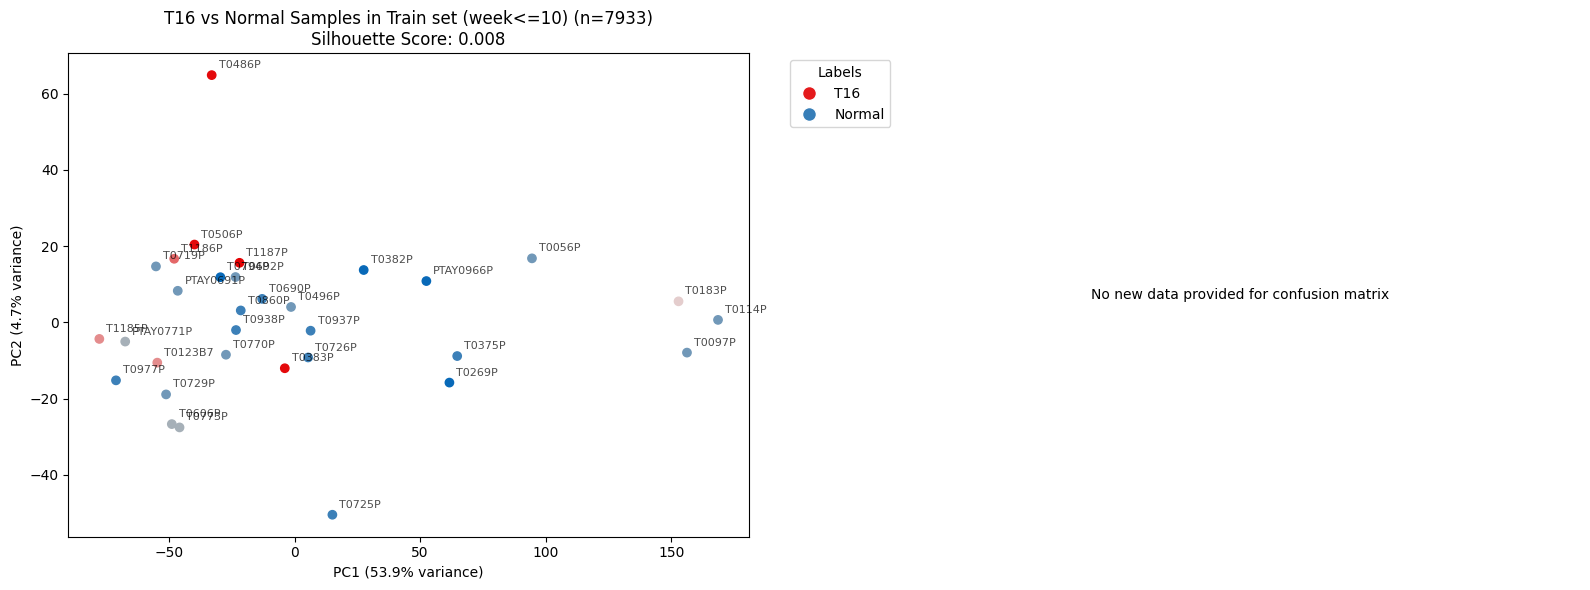

/appsnew/home/syfan/softwares/miniconda3/envs/custom_bert/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


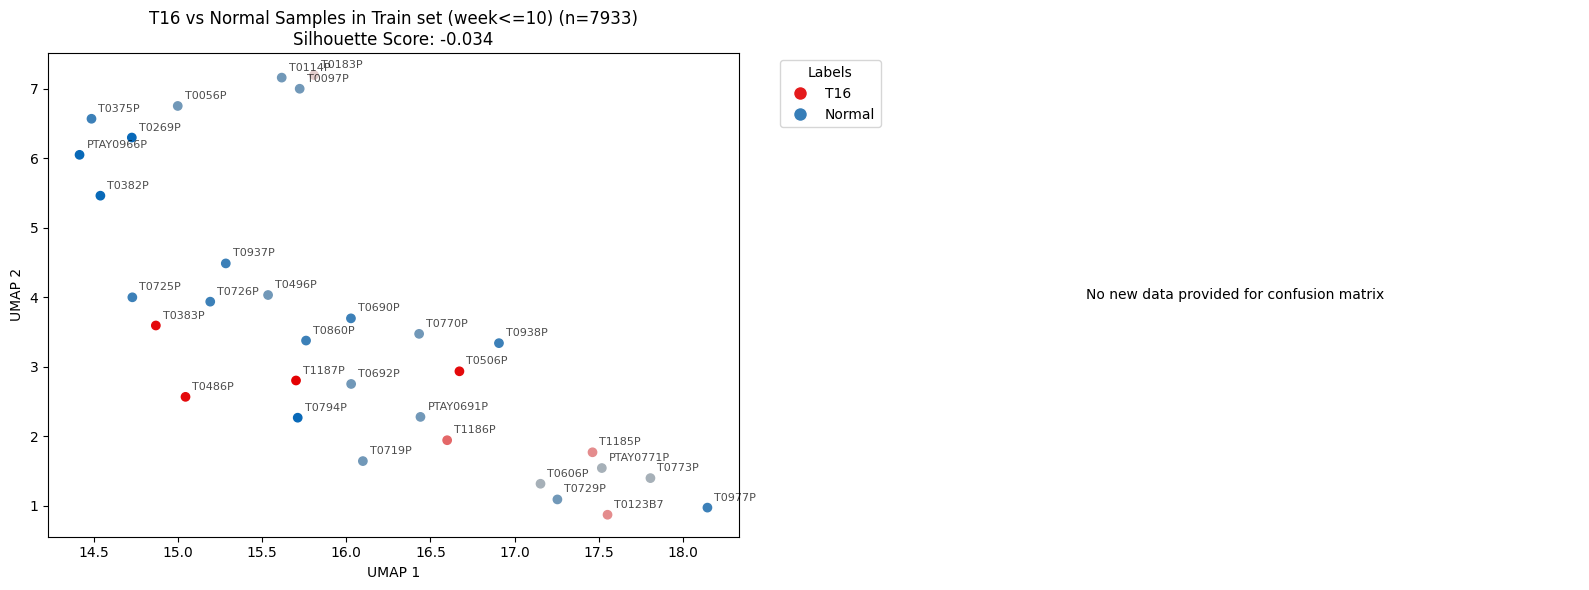

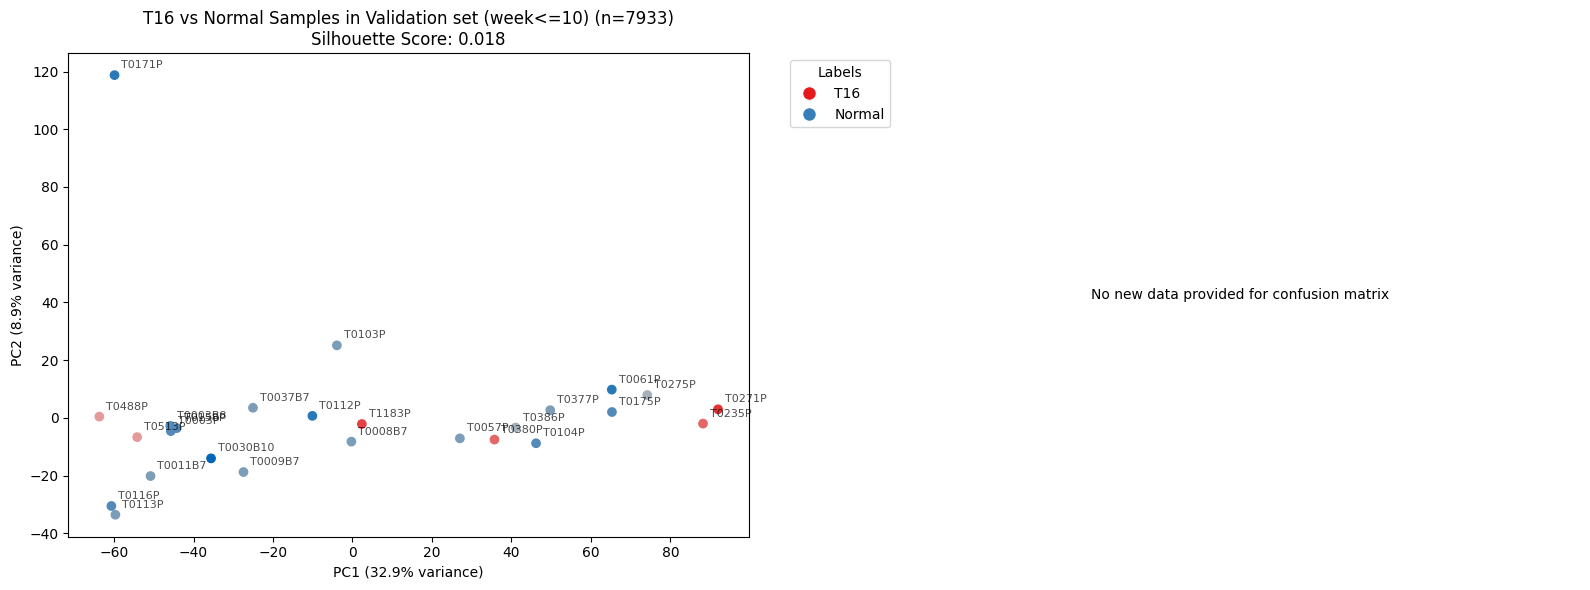

/appsnew/home/syfan/softwares/miniconda3/envs/custom_bert/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


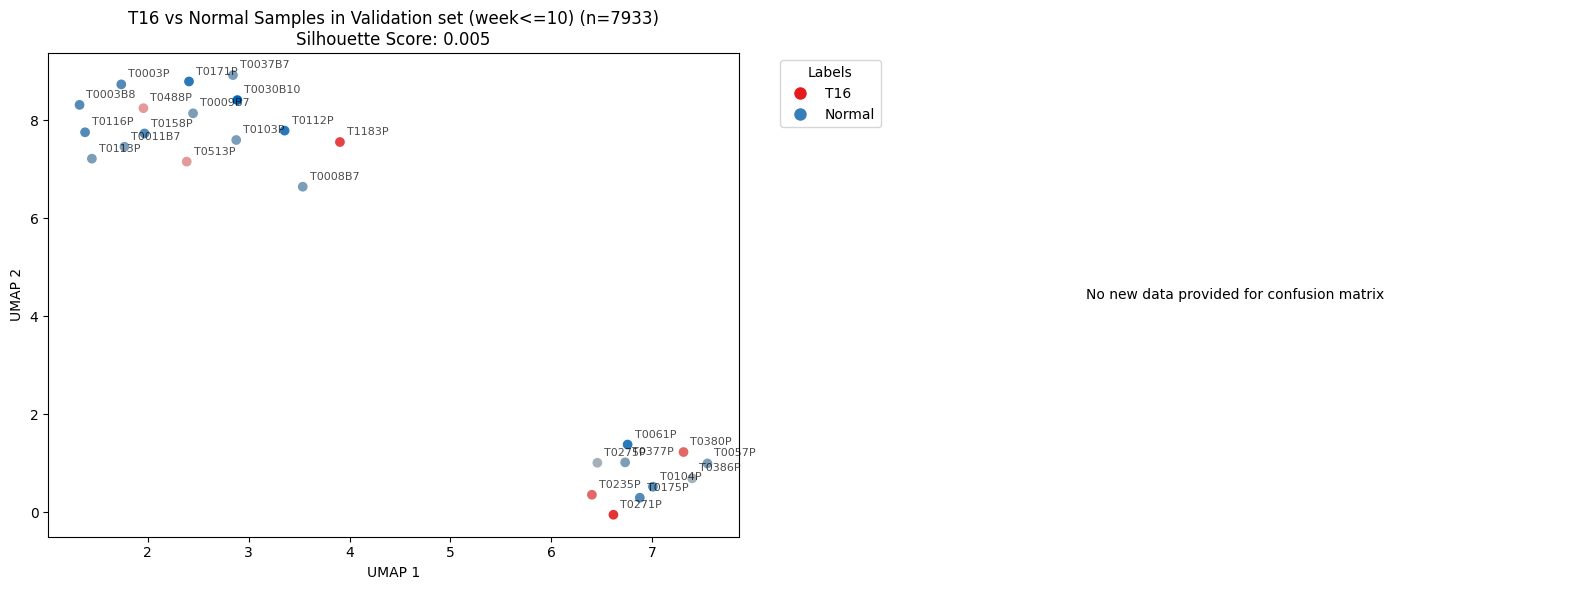

In [28]:
# Plot for single batch

for dataset in ['Train', 'Validation']:
    df = dfs[dataset].copy()
    
    df = convert_beta_to_M(df)
    
    # Filter rows
    state_to_drop = ['Delivered']
    df = df[~df['state'].isin(state_to_drop)]
    
    labels_to_keep = ['T16', 'Normal']
    df = df[df['label'].isin(labels_to_keep)]

    df = df[df['week'] <= 10]
    
    feature_cols = [col for col in df.columns if ':' in col]
    
    cols = ['sample', 'week', 'label'] + feature_cols

    single_pca_plot(df[cols], feature_cols, labels_to_keep, f'T16 vs Normal Samples in {dataset} set (week<=10)', plot_decision_boundary=False)

    single_umap_plot(df[cols], feature_cols, labels_to_keep, f'T16 vs Normal Samples in {dataset} set (week<=10)', plot_decision_boundary=False)

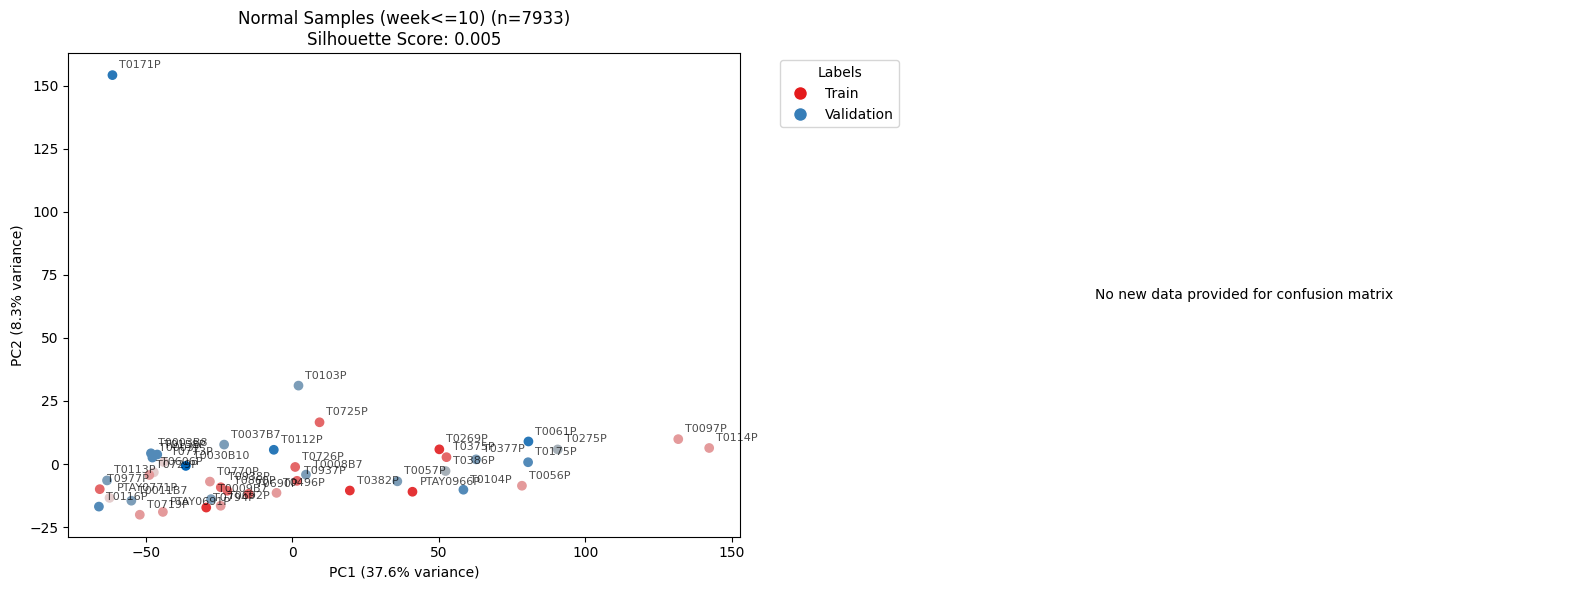

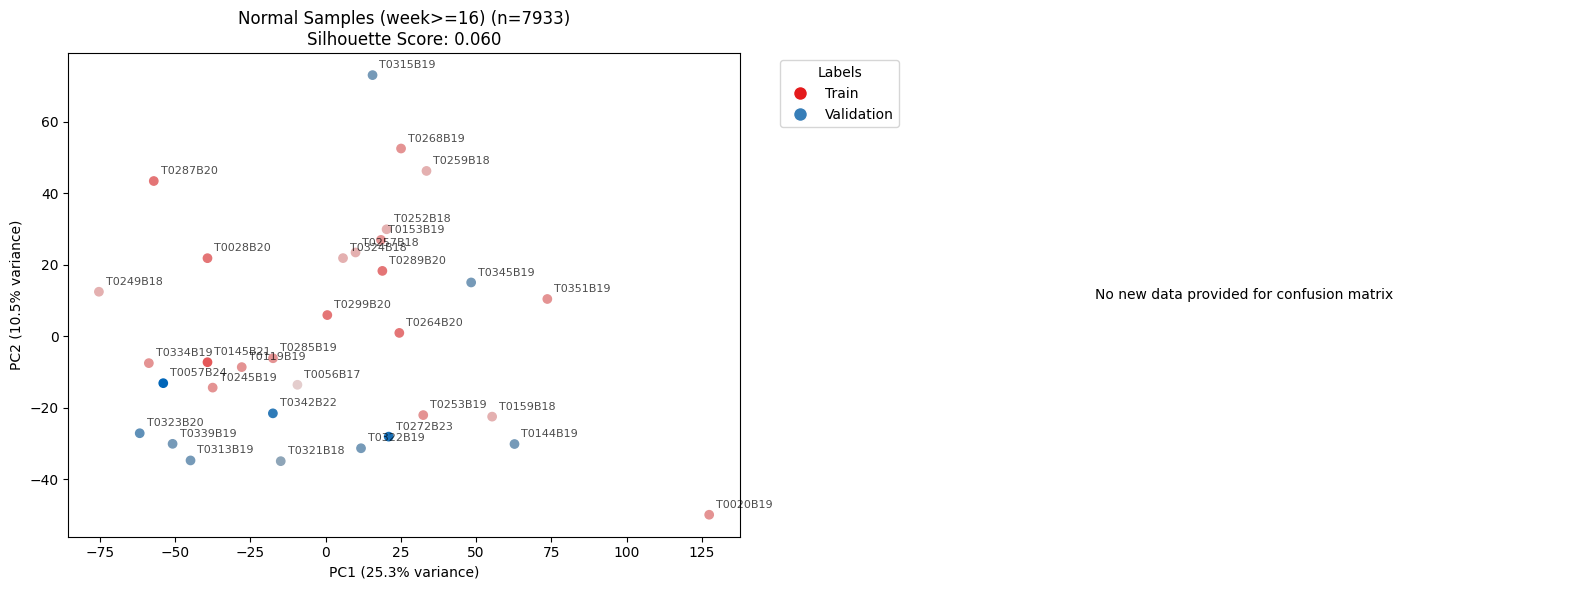

/appsnew/home/syfan/softwares/miniconda3/envs/custom_bert/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


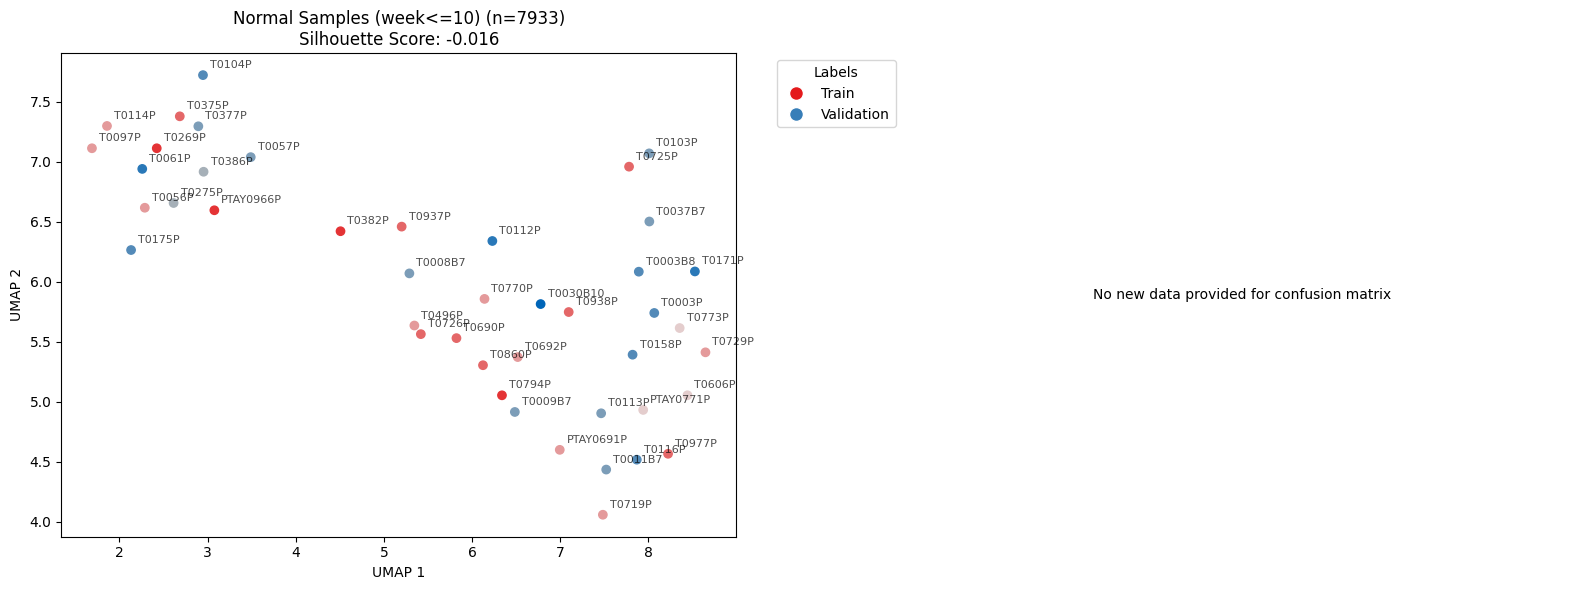

/appsnew/home/syfan/softwares/miniconda3/envs/custom_bert/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


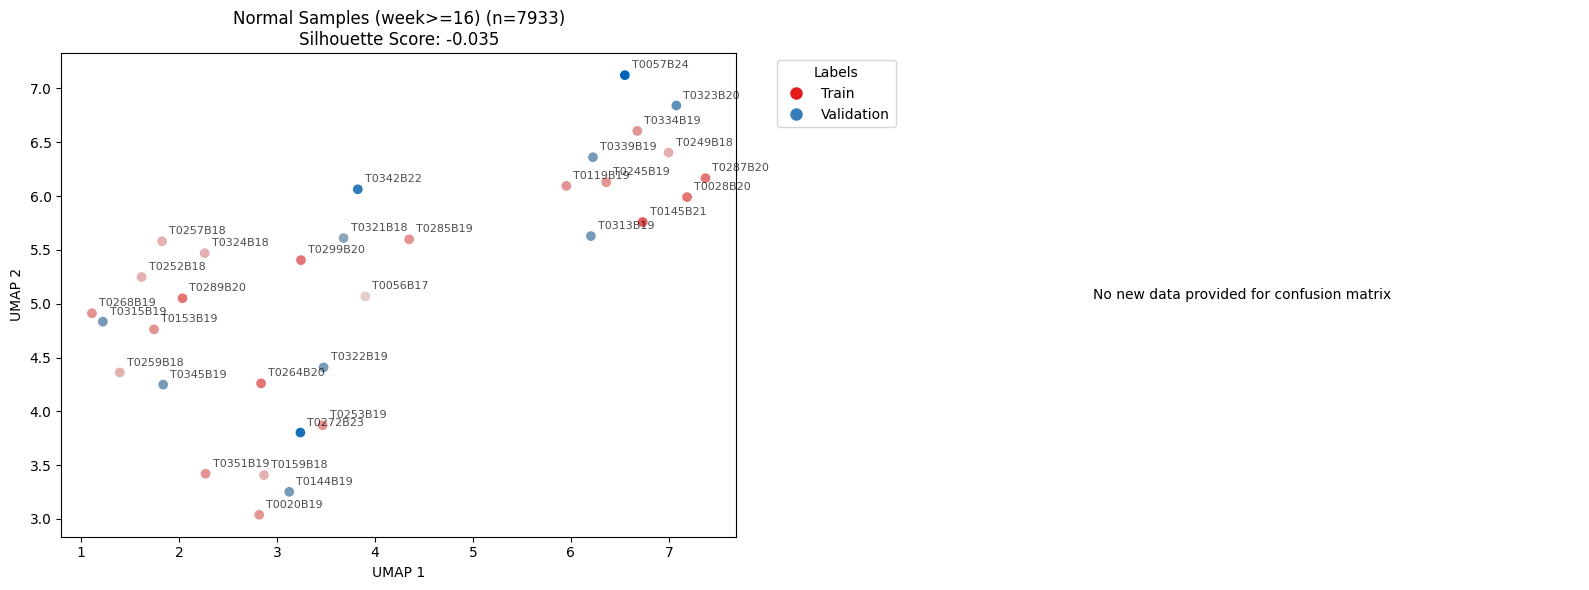

In [29]:
# Check batch effect in normal samples
df_train = dfs['Train'].copy()
df_val = dfs['Validation'].copy()

df_train = convert_beta_to_M(df_train)
df_val = convert_beta_to_M(df_val)

# Filter rows
state_to_drop = ['Delivered']
df_val = df_val[~df_val['state'].isin(state_to_drop)]

labels_to_keep = ['Normal']
df_train = df_train[df_train['label'].isin(labels_to_keep)]
df_val = df_val[df_val['label'].isin(labels_to_keep)]

df_train['label'] = 'Train'
df_val['label'] = 'Validation'

labels_to_keep = ['Train', 'Validation']

df = pd.concat([df_train, df_val], axis=0)

feature_cols = [col for col in df.columns if ':' in col]

cols = ['sample', 'week', 'label'] + feature_cols

single_pca_plot(df[df['week'] <= 10], feature_cols, labels_to_keep, f'Normal Samples (week<=10)', plot_decision_boundary=False)

single_pca_plot(df[df['week'] >= 16], feature_cols, labels_to_keep, f'Normal Samples (week>=16)', plot_decision_boundary=False)

single_umap_plot(df[df['week'] <= 10], feature_cols, labels_to_keep, f'Normal Samples (week<=10)', plot_decision_boundary=False)

single_umap_plot(df[df['week'] >= 16], feature_cols, labels_to_keep, f'Normal Samples (week>=16)', plot_decision_boundary=False)


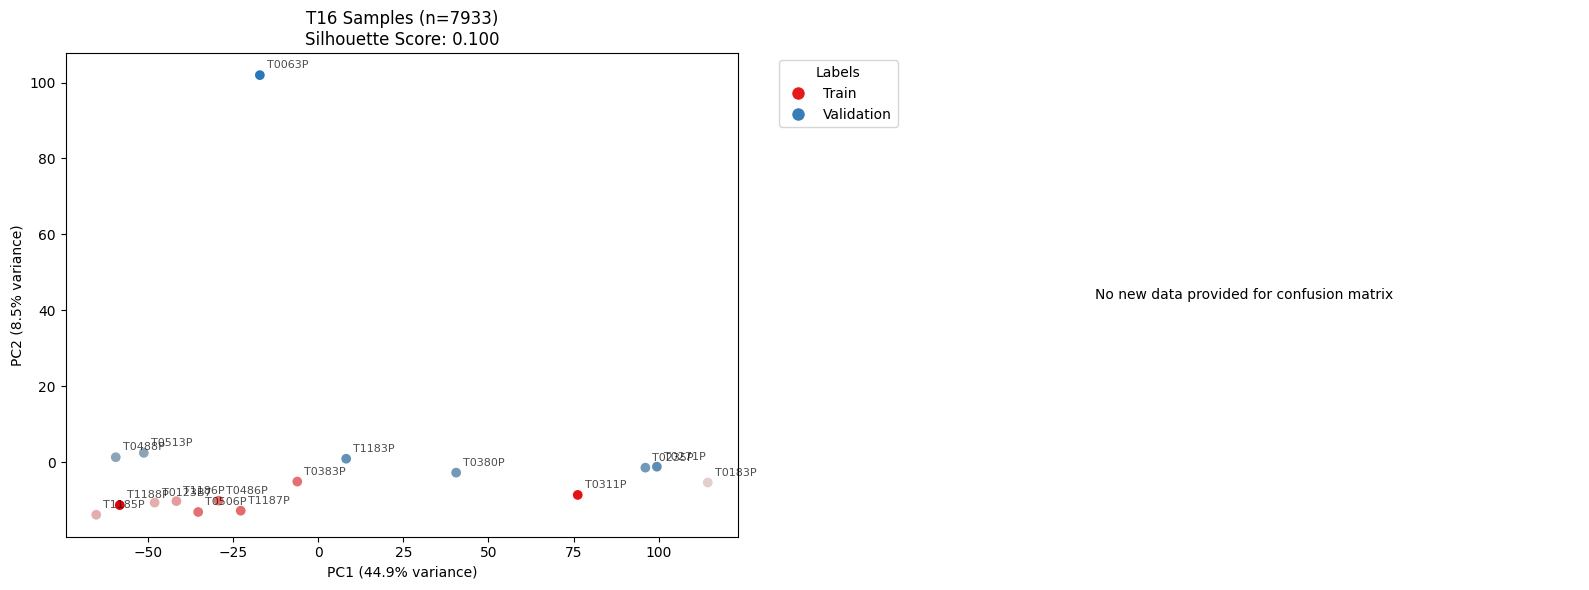

/appsnew/home/syfan/softwares/miniconda3/envs/custom_bert/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


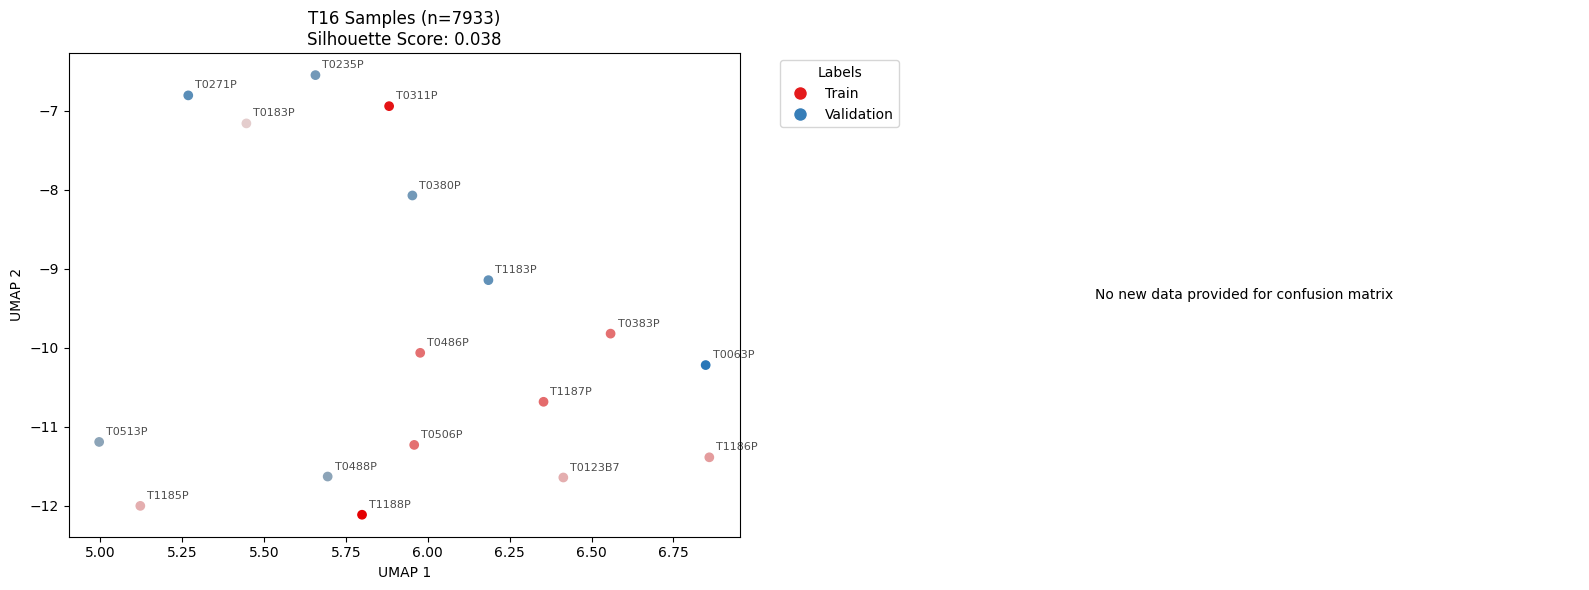

In [30]:
# Check batch effect in T16 samples
df_train = dfs['Train'].copy()
df_val = dfs['Validation'].copy()

df_train = convert_beta_to_M(df_train)
df_val = convert_beta_to_M(df_val)

# Filter rows
state_to_drop = ['Delivered']
df_val = df_val[~df_val['state'].isin(state_to_drop)]

labels_to_keep = ['T16']
df_train = df_train[df_train['label'].isin(labels_to_keep)]
df_val = df_val[df_val['label'].isin(labels_to_keep)]

df_train['label'] = 'Train'
df_val['label'] = 'Validation'

labels_to_keep = ['Train', 'Validation']

df = pd.concat([df_train, df_val], axis=0)

feature_cols = [col for col in df.columns if ':' in col]

cols = ['sample', 'week', 'label'] + feature_cols

single_pca_plot(df, feature_cols, labels_to_keep, f'T16 Samples', plot_decision_boundary=False)

single_umap_plot(df, feature_cols, labels_to_keep, f'T16 Samples', plot_decision_boundary=False)

## Chr Mean Beta Value

In [100]:
# Chr mean beta value boxplot

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_ind

def compute_feature_stats(df, feature_cols):
    """
    Compute t-test p-values and mean differences between 'T21' and 'Normal'
    for a list of feature columns.
    Returns a dataframe summarizing the feature name, p-value, and mean difference.
    """
    stats = []
    for feat in feature_cols:
        group_T21 = df[df['label'] == 'T21'][feat].dropna()
        group_Normal = df[df['label'] == 'Normal'][feat].dropna()
        if len(group_T21) > 1 and len(group_Normal) > 1:
            stat, p_value = ttest_ind(group_T21, group_Normal, equal_var=False)
            mean_diff = group_T21.mean() - group_Normal.mean()
        else:
            p_value = 1.0
            mean_diff = 0.0
        stats.append({'feature': feat, 'p_value': p_value, 'mean_diff': mean_diff})
    
    return pd.DataFrame(stats)

def plot_feature_comparison(df, feature_cols, chr_label):
    """
    Draws a boxplot comparing the distribution of each feature (for a given chromosome)
    between the two labels.
    
    For each feature column, the x-axis shows two boxplots:
      - Left: 'T21'
      - Right: 'Normal'
      
    The features are ordered by the t-test p-value.
    """
    # Melt the DataFrame for easier plotting
    df_melt = pd.melt(df, id_vars=['sample', 'week', 'label'], 
                      value_vars=feature_cols, 
                      var_name='feature', 
                      value_name='value')
    
    # Compute statistics for ordering features
    stats_df = compute_feature_stats(df, feature_cols)
    ordered_features = stats_df.sort_values('p_value')['feature'].tolist()
    
    # Create the boxplot
    plt.figure(figsize=(max(15, len(ordered_features)*0.2), 6))
    ax = sns.boxplot(x='feature', y='value', hue='label', data=df_melt, order=ordered_features)
    plt.xticks(rotation=90)
    plt.xlabel(f'{chr_label} Feature')
    plt.ylabel('Feature Value')
    plt.title(f'{chr_label} Features: Distribution by Label (Ordered by p-value)')
    plt.legend(title='Label')
    plt.tight_layout()
    plt.show()

def plot_aggregated_comparison_all(df, title, label_order=None):
    """
    Computes an aggregated measure (mean across features) for each chromosome from chr1 to chr22
    for each sample and draws a single boxplot comparing the aggregated values between 'T21' and 'Normal'.
    Outlier data points are annotated with the sample name.

    Parameters:
    - df: DataFrame containing the input data.
    - title: Title for the plot.
    - label_order: List specifying the order of the labels in the boxplot. If None, the labels are sorted.
    """
    aggregated_list = []
    
    # Loop through chromosomes 1 to 22
    for chrom in range(1, 23):
        chr_label = f'chr{chrom}'
        # Select feature columns that include the current chromosome
        chr_features = [col for col in df.columns if chr_label in col]
        if not chr_features:
            continue  # Skip if no features for this chromosome
        
        # Compute the aggregated (mean) value across the features for each sample
        df_chr = df.copy()
        df_chr['aggregated_value'] = df_chr[chr_features].mean(axis=1)
        df_chr['chromosome'] = chr_label
        # Only keep the needed columns
        aggregated_list.append(df_chr[['sample', 'week', 'label', 'chromosome', 'aggregated_value']])
    
    # Combine aggregated values for all chromosomes
    if aggregated_list:
        agg_df = pd.concat(aggregated_list, axis=0)
    else:
        print("No chromosome features found.")
        return
    
    # Determine the order for chromosomes
    order = sorted(agg_df['chromosome'].unique(), key=lambda x: int(x.replace('chr', '')))
    # Determine the hue order based on label_order parameter or default sorted order
    hue_order = label_order if label_order is not None else sorted(agg_df['label'].unique())
    
    # Create the boxplot: one boxplot per chromosome, with hue for the label
    plt.figure(figsize=(15, 6))
    ax = sns.boxplot(x='chromosome', y='aggregated_value', hue='label', data=agg_df, 
                     order=order, hue_order=hue_order)
    plt.xlabel('Chromosome')
    plt.ylabel('Mean Beta Value')
    plt.title(f'{title}')
    # Move the legend out of the main plot (to the right)
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # For each group (chromosome and label), compute outlier bounds and annotate outliers with sample names
    groups = agg_df.groupby(['chromosome', 'label'])
    for (chrom, label), group in groups:
        Q1 = group['aggregated_value'].quantile(0.25)
        Q3 = group['aggregated_value'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = group[(group['aggregated_value'] < lower_bound) | (group['aggregated_value'] > upper_bound)]
        
        for _, row in outliers.iterrows():
            # Calculate x position:
            # Each chromosome's box is centered at its integer index according to the sorted order,
            # then adjusted by an offset that depends on the label's position within hue_order.
            x_cat = order.index(chrom)  # central x position for the chromosome
            n_hues = len(hue_order)
            hue_index = hue_order.index(label)
            # Assuming the total width for the boxes in each category is 0.8,
            # compute an offset so that boxes are spaced evenly.
            offset = (hue_index - (n_hues - 1) / 2) * (0.8 / n_hues)
            x_val = x_cat + offset
            
            y_val = row['aggregated_value']
            # Annotate the outlier point with its sample name
            ax.text(x_val, y_val, str(row['sample']),
                    horizontalalignment='center', verticalalignment='bottom',
                    fontsize=8, color='black')
    
    plt.tight_layout()
    plt.show()

chr21 feature comparison


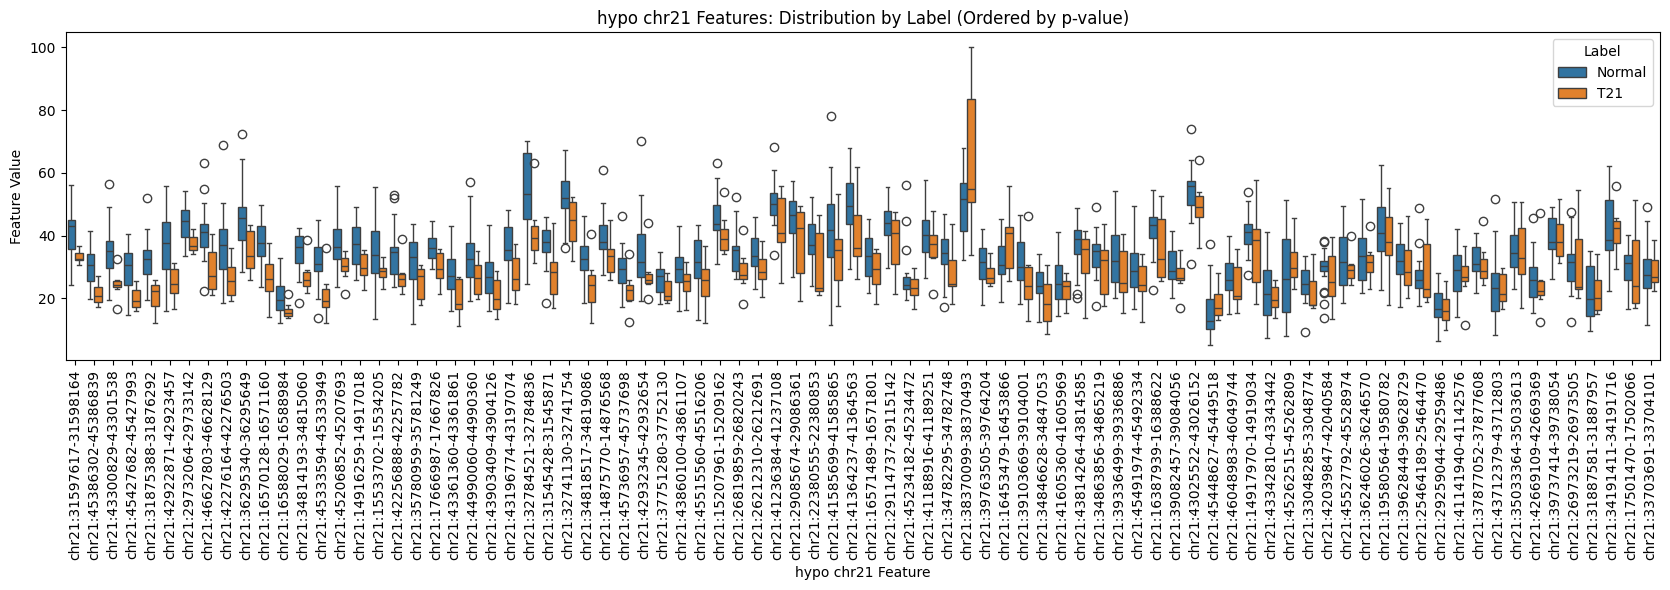

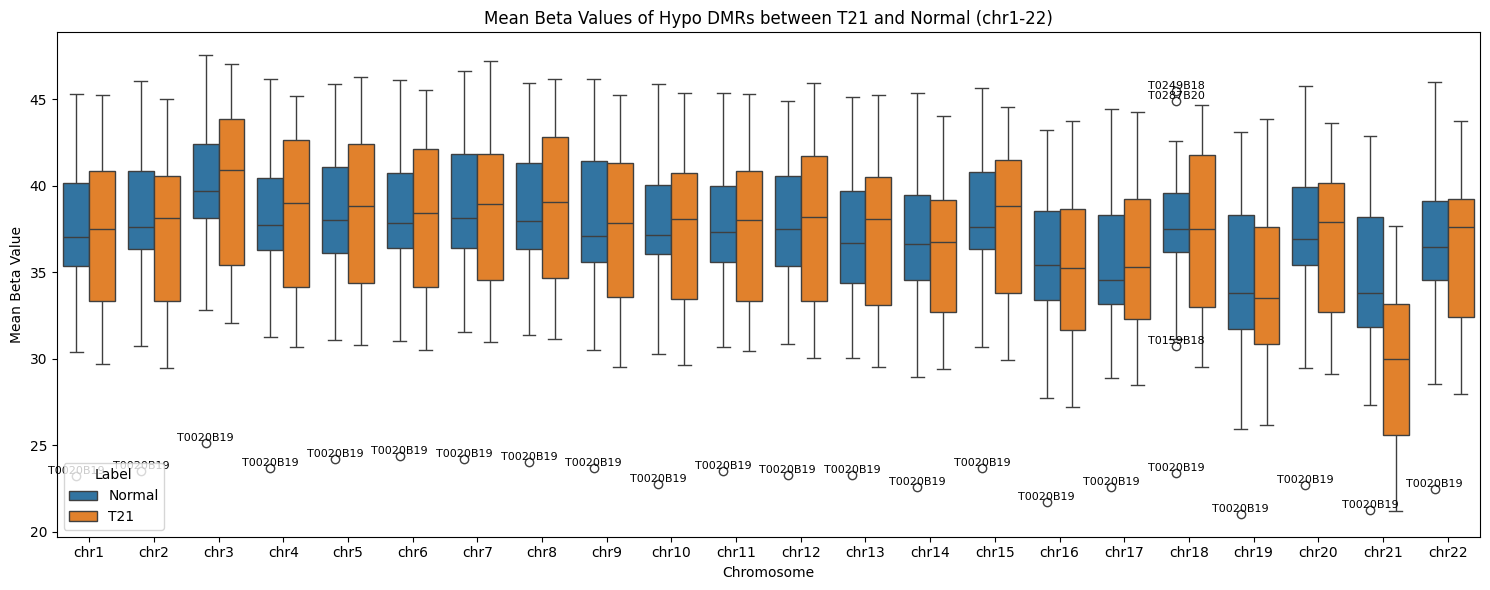

In [89]:
# T21

# Combine Train and Validation data
# df = pd.concat([dfs['Train'], dfs['Validation']], axis=0)
df = dfs['Train']

# Convert beta to M values
# df = convert_beta_to_M(df)

# Filter rows:
# 1. Remove delivered data
df = df[~df['state'].isin(['Delivered'])]

# 2. Keep only T21 and Normal labels
df = df[df['label'].isin(['T21', 'Normal'])]

# 3. Keep week >= 15 samples
df = df[df['week'] >= 15]

# 1. Draw feature comparison for chr21 only
feature_cols = [col for col in df.columns if 'chr21' in col]

hypo_feature_cols = list(set(feature_cols) & set(hypo_dmrs))
hyper_feature_cols = list(set(feature_cols) & set(hyper_dmrs))

print(f"chr21 feature comparison")
plot_feature_comparison(df, hypo_feature_cols, 'hypo chr21')

# 2. Draw aggregated comparison for each chromosome from chr1 to chr22 in one boxplot
feature_cols = [col for col in df.columns if ':' in col]

hypo_feature_cols = ['sample', 'week', 'label'] + list(set(feature_cols) & set(hypo_dmrs))

plot_aggregated_comparison_all(df[hypo_feature_cols], 'Hypo')

In [90]:
filtered_dmr = pd.read_csv('../results/DMR_refine/senddmr_2272.bed', sep='\t', names=['chr', 'start', 'end'])
filtered_dmr['coordinate'] = filtered_dmr['chr'].astype(str) + ':' + filtered_dmr['start'].astype(str) + '-' + filtered_dmr['end'].astype(str)
filtered_dmr_list = list(filtered_dmr['coordinate'])

chr21 feature comparison


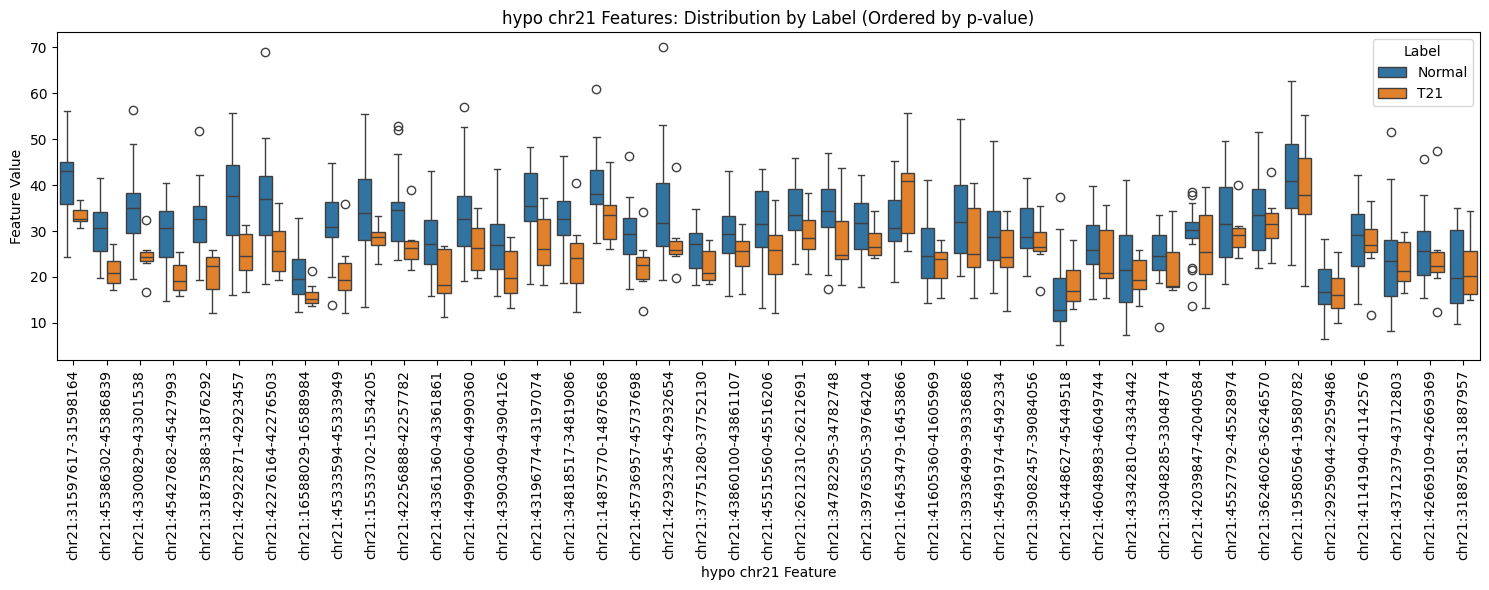

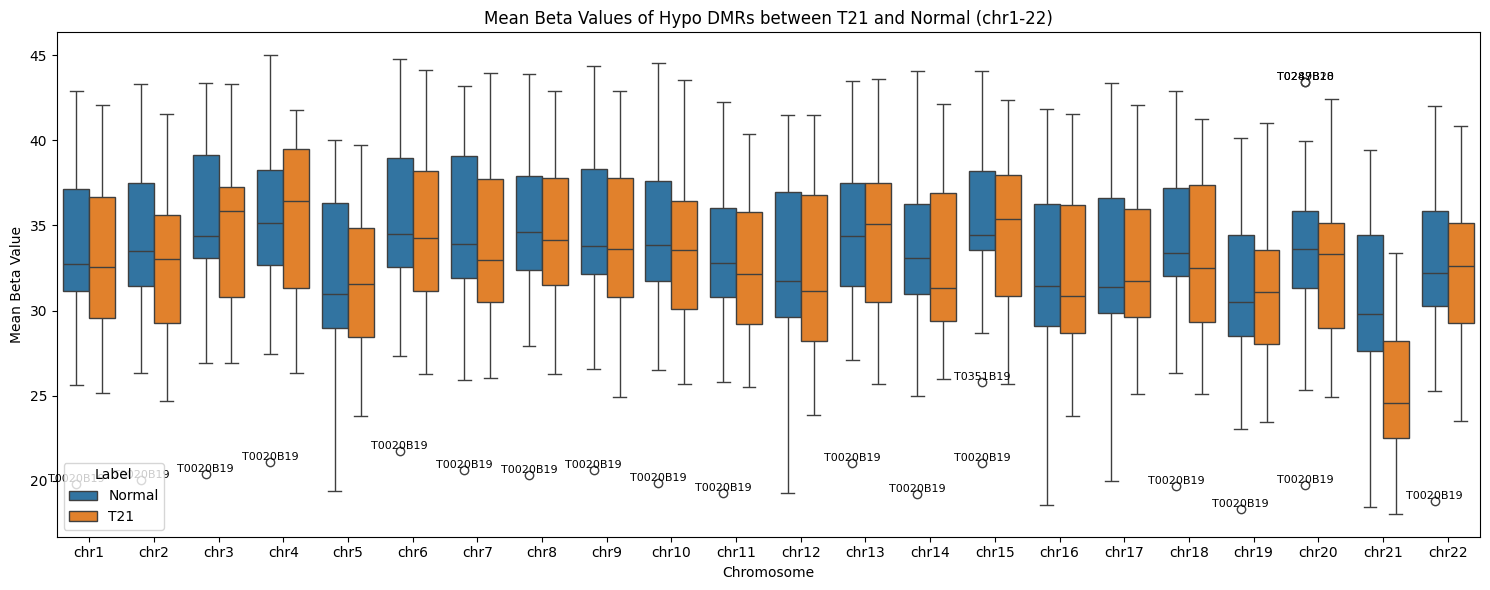

In [91]:
# Combine Train and Validation data
# df = pd.concat([dfs['Train'], dfs['Validation']], axis=0)
df = dfs['Train']

# Convert beta to M values
# df = convert_beta_to_M(df)

# Filter rows:
# 1. Remove delivered data
df = df[~df['state'].isin(['Delivered'])]

# 2. Keep only T21 and Normal labels
df = df[df['label'].isin(['T21', 'Normal'])]

# 3. Keep week >= 15 samples
df = df[df['week'] >= 15]

# 1. Draw feature comparison for chr21 only
feature_cols = [col for col in df.columns if (col in filtered_dmr_list) & ('chr21' in col)]

hypo_feature_cols = list(set(feature_cols) & set(hypo_dmrs))
hyper_feature_cols = list(set(feature_cols) & set(hyper_dmrs))

print(f"chr21 feature comparison")
plot_feature_comparison(df, hypo_feature_cols, 'hypo chr21')

# 2. Draw aggregated comparison for each chromosome from chr1 to chr22 in one boxplot
feature_cols = [col for col in df.columns if col in filtered_dmr_list]

hypo_feature_cols = ['sample', 'week', 'label'] + list(set(feature_cols) & set(hypo_dmrs))

plot_aggregated_comparison_all(df[hypo_feature_cols], 'Hypo')

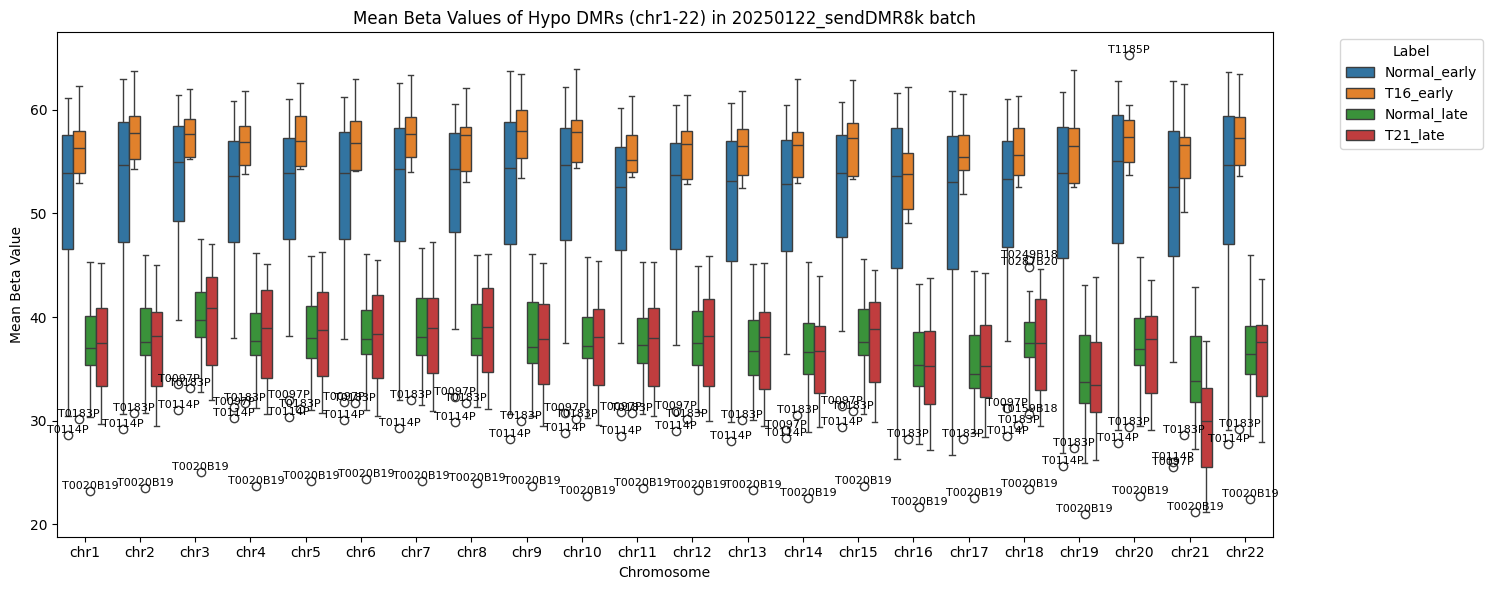

In [139]:
# T16

# Combine Train and Validation data
# df = pd.concat([dfs['Train'], dfs['Validation']], axis=0)
df = dfs['Train']

# Convert beta to M values
# df = convert_beta_to_M(df)

# Filter rows:
# 1. Remove delivered data
df = df[~df['state'].isin(['Delivered'])]

# 2. Keep T16, T21 and Normal labels
df = df[df['label'].isin(['T21', 'T16', 'Normal'])]

# 3. Add week info to label
df = df[(df['week'] <= 10) | (df['week'] >= 15)].copy()
df['label'] = np.where(
    df['week'] <= 10,
    df['label'] + '_early',
    df['label'] + '_late'
)

# Draw aggregated comparison for each chromosome from chr1 to chr22 in one boxplot
feature_cols = [col for col in df.columns if ':' in col]

hypo_feature_cols = ['sample', 'week', 'label'] + list(set(feature_cols) & set(hypo_dmrs))

plot_aggregated_comparison_all(df[hypo_feature_cols], 'Mean Beta Values of Hypo DMRs (chr1-22) in 20250122_sendDMR8k batch', ['Normal_early', 'T16_early', 'Normal_late', 'T21_late'])

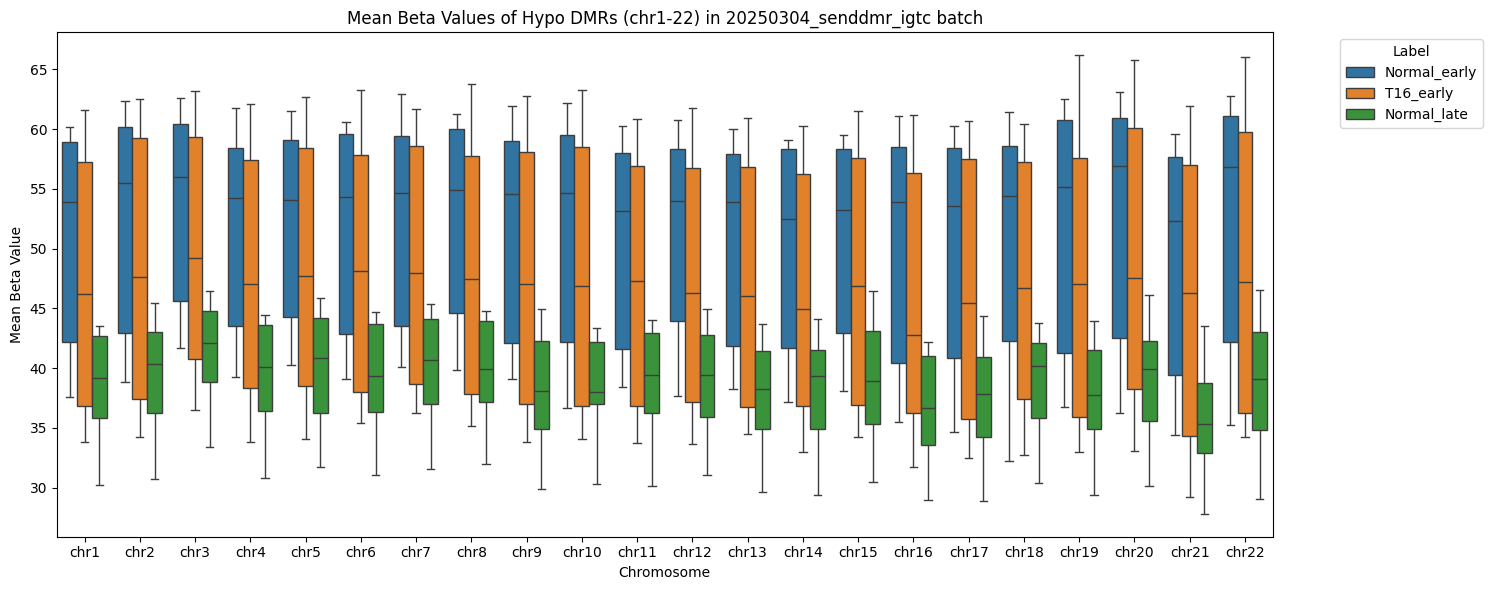

In [140]:
# T16

# Combine Train and Validation data
# df = pd.concat([dfs['Train'], dfs['Validation']], axis=0)
df = dfs['Validation']

# Convert beta to M values
# df = convert_beta_to_M(df)

# Filter rows:
# 1. Remove delivered data
df = df[~df['state'].isin(['Delivered'])]

# 2. Keep T16, T21 and Normal labels
df = df[df['label'].isin(['T16', 'Normal'])]

# 3. Add week info to label
df = df[(df['week'] <= 10) | (df['week'] >= 15)].copy()
df['label'] = np.where(
    df['week'] <= 10,
    df['label'] + '_early',
    df['label'] + '_late'
)

# Draw aggregated comparison for each chromosome from chr1 to chr22 in one boxplot
feature_cols = [col for col in df.columns if ':' in col]

hypo_feature_cols = ['sample', 'week', 'label'] + list(set(feature_cols) & set(hypo_dmrs))

plot_aggregated_comparison_all(df[hypo_feature_cols], 'Mean Beta Values of Hypo DMRs (chr1-22) in 20250304_senddmr_igtc batch', ['Normal_early', 'T16_early', 'Normal_late'])

In [117]:
from scipy.stats import ttest_ind

def feature_selection(df, hypo_feature_cols, p_threshold=0.05):
    """
    Filters hypo_feature_cols by testing for significant differences in feature values 
    between specified groups:
    
    1. For columns starting with 'chr16', compares 'T16_early' vs. 'Normal_early'.
    2. For columns starting with 'chr21', compares 'T21_late' vs. 'Normal_late'.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the data. It must include a 'label' column.
    hypo_feature_cols : list
        List of column names including metadata (e.g., 'sample', 'week', 'label') 
        and the feature columns to be tested.
    p_threshold : float, optional
        The significance level to use (default is 0.05).
    
    Returns
    -------
    selected_features : list
        List of feature columns (from hypo_feature_cols) that are significantly 
        different between the specified groups.
    """
    selected_features = []
    
    # Loop over the feature columns, skipping metadata columns.
    for col in hypo_feature_cols:
        if col in ['sample', 'week', 'label']:
            continue
                    
        # For features from chromosome 21: compare T21_late vs Normal_late.
        if col.startswith('chr21'):
            group1 = df[df['label'] == 'T21_late'][col].dropna()
            group2 = df[df['label'] == 'Normal_late'][col].dropna()
            if len(group1) > 1 and len(group2) > 1:
                stat, p_val = ttest_ind(group1, group2, equal_var=False)
                if p_val < p_threshold:
                    selected_features.append(col)
    
    return selected_features

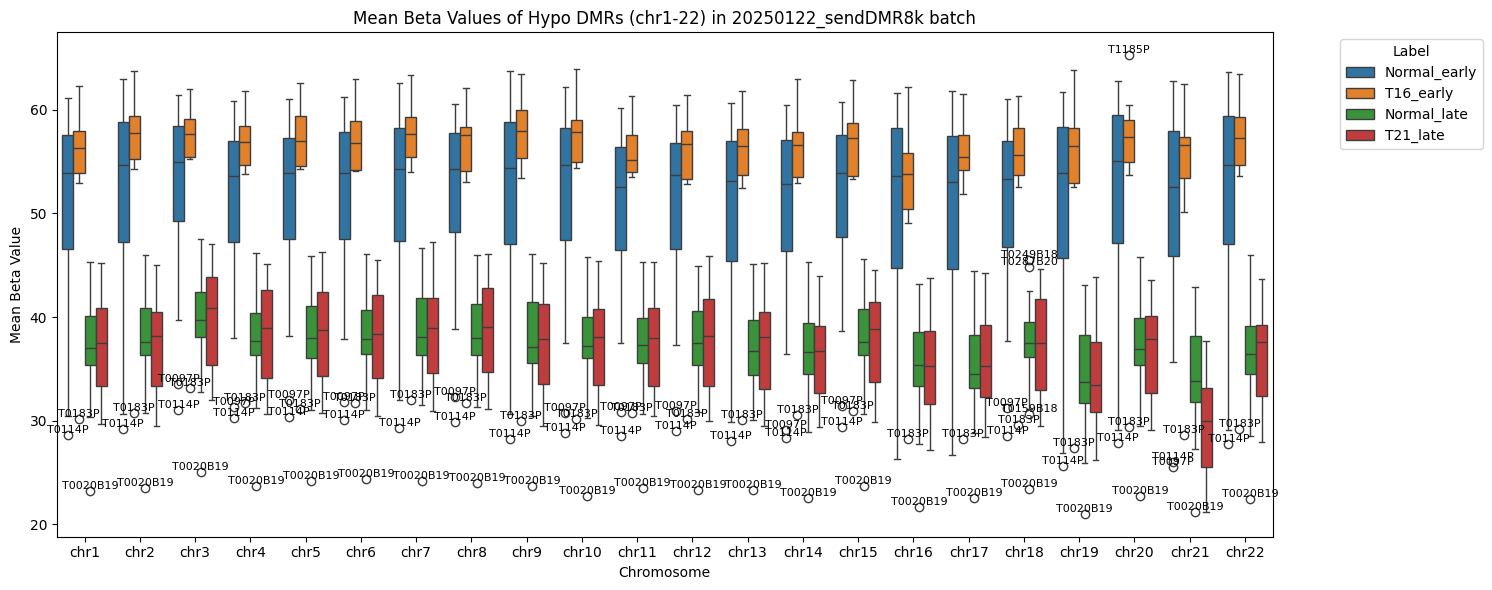

In [119]:
# T16

# Combine Train and Validation data
df = dfs['Train']

# Convert beta to M values
# df = convert_beta_to_M(df)

# Filter rows:
# 1. Remove delivered data
df = df[~df['state'].isin(['Delivered'])]

# 2. Keep T16, T21 and Normal labels
df = df[df['label'].isin(['T21', 'T16', 'Normal'])]

# 3. Add week info to label
df = df[(df['week'] <= 10) | (df['week'] >= 15)].copy()
df['label'] = np.where(
    df['week'] <= 10,
    df['label'] + '_early',
    df['label'] + '_late'
)

# Draw aggregated comparison for each chromosome from chr1 to chr22 in one boxplot
feature_cols = [col for col in df.columns if ':' in col]

hypo_feature_cols = ['sample', 'week', 'label'] + list(set(feature_cols) & set(hypo_dmrs))

# hypo_feature_cols = ['sample', 'week', 'label'] + feature_selection(df, hypo_feature_cols, p_threshold=0.05)

plot_aggregated_comparison_all(df[hypo_feature_cols], 'Mean Beta Values of Hypo DMRs (chr1-22) in 20250122_sendDMR8k batch', ['Normal_early', 'T16_early', 'Normal_late', 'T21_late'])

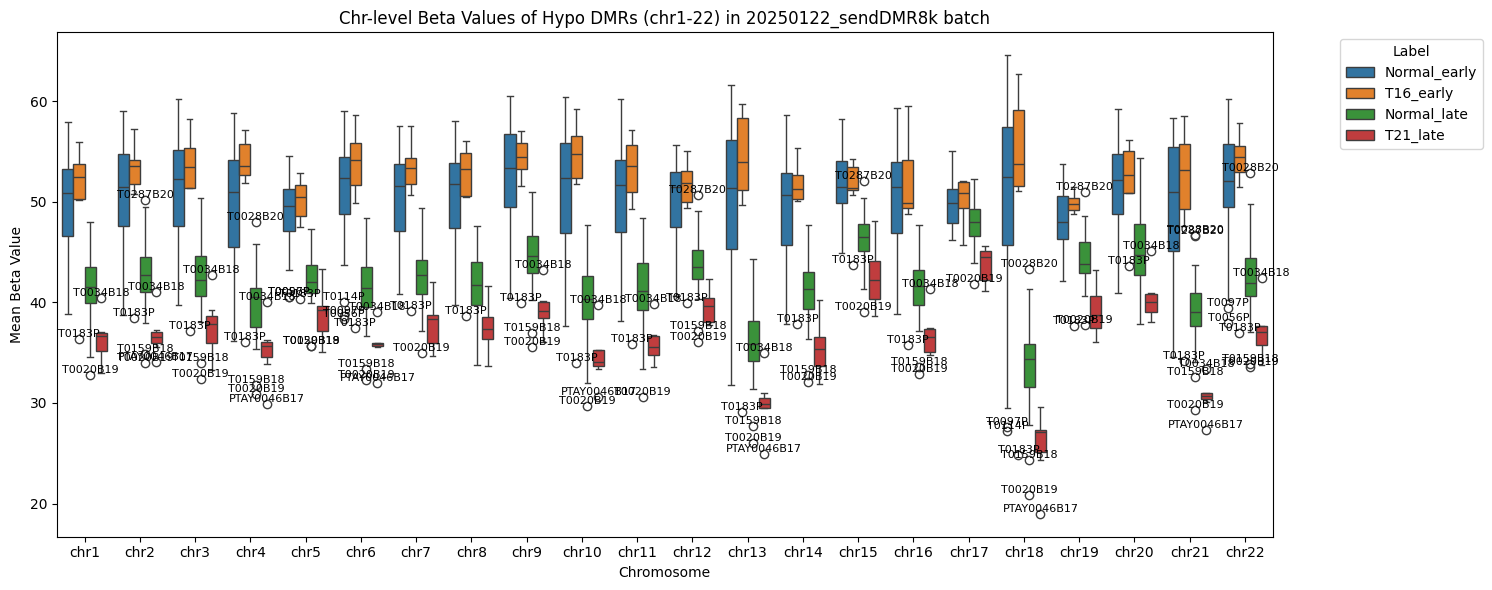

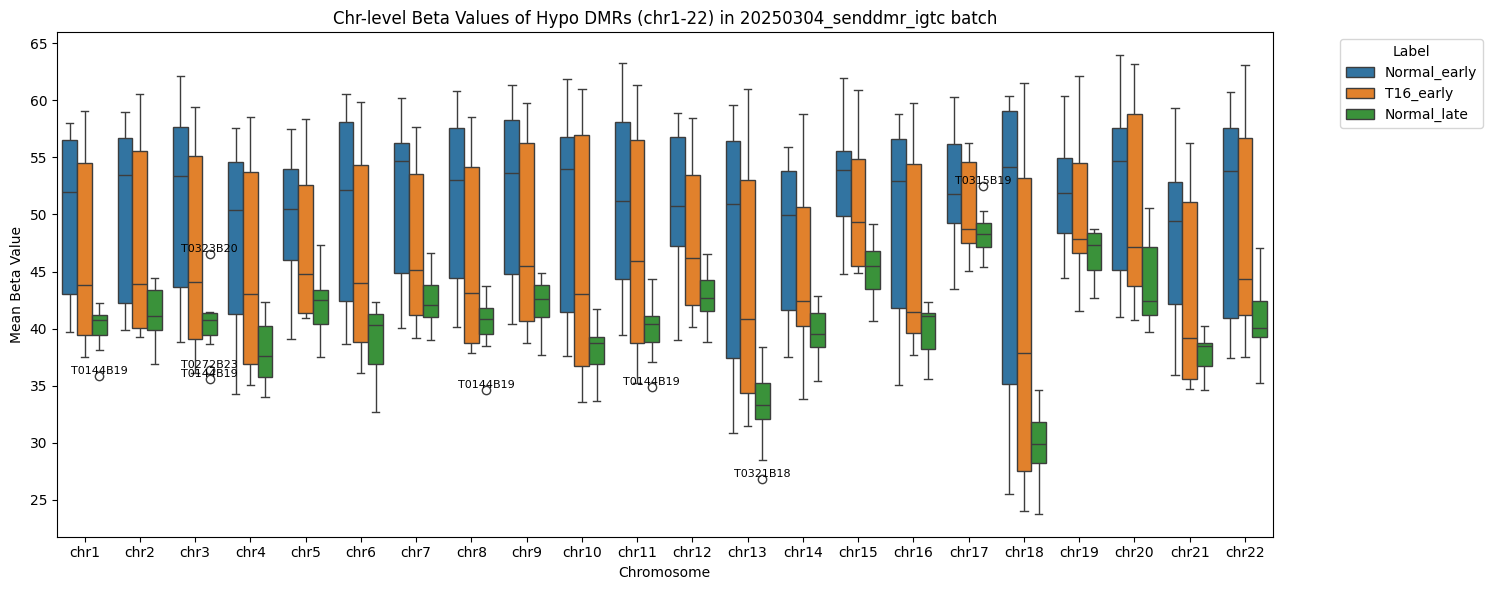

In [144]:
# Create nested dictionary structure for easier access
feature_type = 'dmrs'
# feature_type = 'cpgs'

dfs = {
    'Train': pd.read_csv(f'../results/20250318_train/generate/chr_level_chr_level.tsv', sep='\t').dropna(axis=1).drop(columns=['label']),
    'Validation': pd.read_csv(f'../results/20250318_val/generate/chr_level_chr_level.tsv', sep='\t').dropna(axis=1).drop(columns=['label'])
}

# Filter for common columns between train and val for each assembly type
common_cols = set(dfs['Train'].columns) & set(dfs['Validation'].columns)
dfs['Train'] = dfs['Train'][list(common_cols)]
dfs['Validation'] = dfs['Validation'][list(common_cols)]

# Load and combine metadata
train_metadata = pd.read_csv(f'../results/summary/train_meta.csv')
val_metadata = pd.read_csv(f'../results/summary/val_meta.csv')
train_metadata['state'] = 'Arrest'
meta = pd.concat([train_metadata, val_metadata], axis=0)
meta['sample'] = meta['sample'].apply(lambda x: x.replace('H1', ''))
meta['label'] = meta['label'].apply(lambda x: x.replace('T21+Indel_21', 'T21'))
meta['label'] = meta['label'].apply(lambda x: x.replace('T18[50%]', 'T18'))

# Merge metadata with each dataset
for split in list(dfs.keys()):
    df = dfs[split].copy()
    df['sample'] = df['sample'].apply(lambda x: x.replace('H1', ''))
    df = pd.merge(df, meta.drop_duplicates(), on='sample', how='inner')
    dfs[split] = df

# T16

# Combine Train and Validation data
# df = pd.concat([dfs['Train'], dfs['Validation']], axis=0)
df = dfs['Train']

# Convert beta to M values
# df = convert_beta_to_M(df)

# Filter rows:
# 1. Remove delivered data
df = df[~df['state'].isin(['Delivered'])]

# 2. Keep T16, T21 and Normal labels
df = df[df['label'].isin(['T21', 'T16', 'Normal'])]

# 3. Add week info to label
df = df[(df['week'] <= 10) | (df['week'] >= 15)].copy()
df['label'] = np.where(
    df['week'] <= 10,
    df['label'] + '_early',
    df['label'] + '_late'
)

plot_aggregated_comparison_all(df, 'Chr-level Beta Values of Hypo DMRs (chr1-22) in 20250122_sendDMR8k batch', ['Normal_early', 'T16_early', 'Normal_late', 'T21_late'])


# T16

# Combine Train and Validation data
# df = pd.concat([dfs['Train'], dfs['Validation']], axis=0)
df = dfs['Validation']

# Convert beta to M values
# df = convert_beta_to_M(df)

# Filter rows:
# 1. Remove delivered data
df = df[~df['state'].isin(['Delivered'])]

# 2. Keep T16, T21 and Normal labels
df = df[df['label'].isin(['T16', 'Normal'])]

# 3. Add week info to label
df = df[(df['week'] <= 10) | (df['week'] >= 15)].copy()
df['label'] = np.where(
    df['week'] <= 10,
    df['label'] + '_early',
    df['label'] + '_late'
)

plot_aggregated_comparison_all(df, 'Chr-level Beta Values of Hypo DMRs (chr1-22) in 20250304_senddmr_igtc batch', ['Normal_early', 'T16_early', 'Normal_late'])

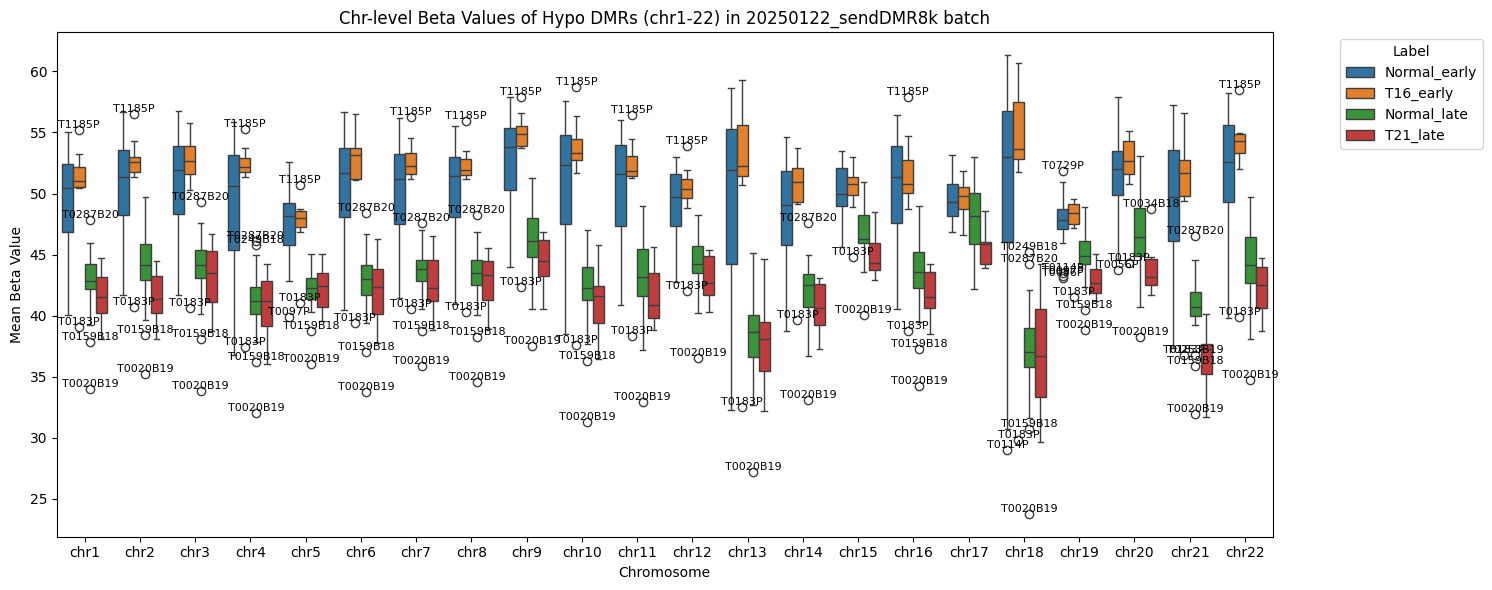

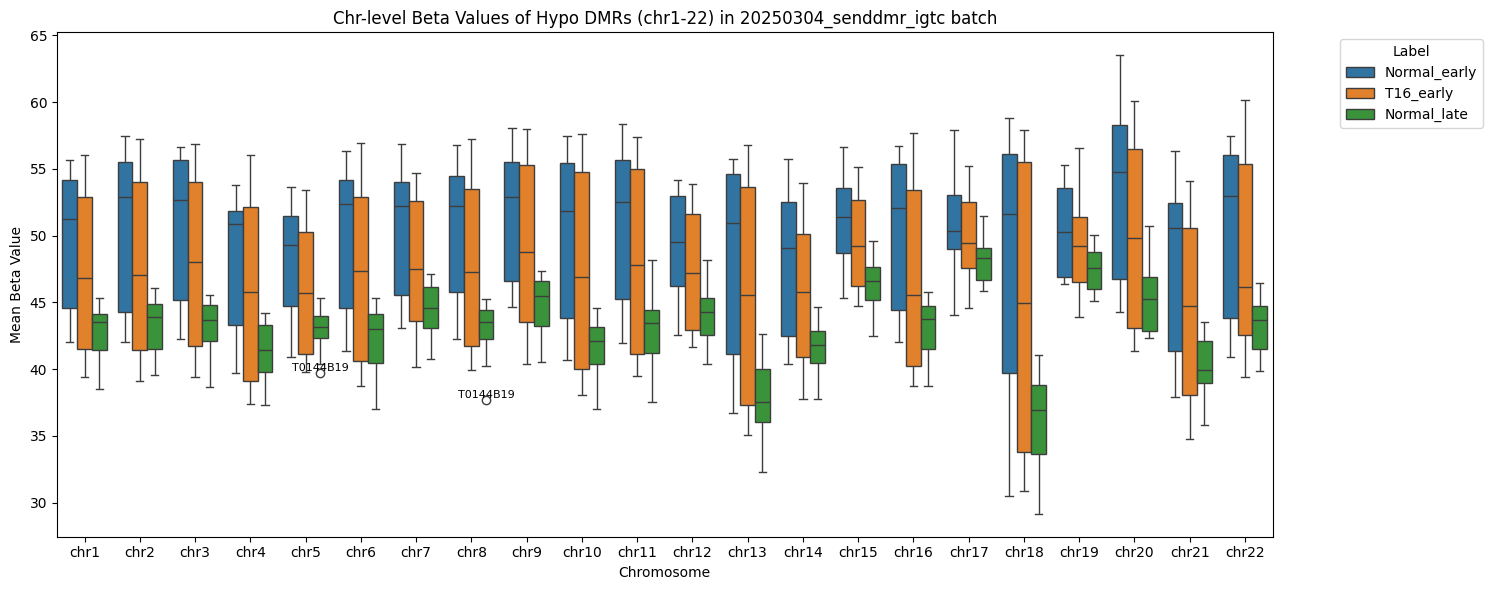

In [145]:
# Create nested dictionary structure for easier access
feature_type = 'dmrs'
# feature_type = 'cpgs'

dfs = {
    'Train': pd.read_csv(f'../results/20250318_train/generate/chr_level_no_fg_chr_level.tsv', sep='\t').dropna(axis=1).drop(columns=['label']),
    'Validation': pd.read_csv(f'../results/20250318_val/generate/chr_level_no_fg_chr_level.tsv', sep='\t').dropna(axis=1).drop(columns=['label'])
}

# Filter for common columns between train and val for each assembly type
common_cols = set(dfs['Train'].columns) & set(dfs['Validation'].columns)
dfs['Train'] = dfs['Train'][list(common_cols)]
dfs['Validation'] = dfs['Validation'][list(common_cols)]

# Load and combine metadata
train_metadata = pd.read_csv(f'../results/summary/train_meta.csv')
val_metadata = pd.read_csv(f'../results/summary/val_meta.csv')
train_metadata['state'] = 'Arrest'
meta = pd.concat([train_metadata, val_metadata], axis=0)
meta['sample'] = meta['sample'].apply(lambda x: x.replace('H1', ''))
meta['label'] = meta['label'].apply(lambda x: x.replace('T21+Indel_21', 'T21'))
meta['label'] = meta['label'].apply(lambda x: x.replace('T18[50%]', 'T18'))

# Merge metadata with each dataset
for split in list(dfs.keys()):
    df = dfs[split].copy()
    df['sample'] = df['sample'].apply(lambda x: x.replace('H1', ''))
    df = pd.merge(df, meta.drop_duplicates(), on='sample', how='inner')
    dfs[split] = df

# T16

# Combine Train and Validation data
# df = pd.concat([dfs['Train'], dfs['Validation']], axis=0)
df = dfs['Train']

# Convert beta to M values
# df = convert_beta_to_M(df)

# Filter rows:
# 1. Remove delivered data
df = df[~df['state'].isin(['Delivered'])]

# 2. Keep T16, T21 and Normal labels
df = df[df['label'].isin(['T21', 'T16', 'Normal'])]

# 3. Add week info to label
df = df[(df['week'] <= 10) | (df['week'] >= 15)].copy()
df['label'] = np.where(
    df['week'] <= 10,
    df['label'] + '_early',
    df['label'] + '_late'
)

plot_aggregated_comparison_all(df, 'Chr-level Beta Values of Hypo DMRs (chr1-22) in 20250122_sendDMR8k batch', ['Normal_early', 'T16_early', 'Normal_late', 'T21_late'])


# T16

# Combine Train and Validation data
# df = pd.concat([dfs['Train'], dfs['Validation']], axis=0)
df = dfs['Validation']

# Convert beta to M values
# df = convert_beta_to_M(df)

# Filter rows:
# 1. Remove delivered data
df = df[~df['state'].isin(['Delivered'])]

# 2. Keep T16, T21 and Normal labels
df = df[df['label'].isin(['T16', 'Normal'])]

# 3. Add week info to label
df = df[(df['week'] <= 10) | (df['week'] >= 15)].copy()
df['label'] = np.where(
    df['week'] <= 10,
    df['label'] + '_early',
    df['label'] + '_late'
)

plot_aggregated_comparison_all(df, 'Chr-level Beta Values of Hypo DMRs (chr1-22) in 20250304_senddmr_igtc batch', ['Normal_early', 'T16_early', 'Normal_late'])